# Проект 4. Компьютер говорит «Нет» (SF DST-60)
## (Георгий Виногродский)

Цель проекта - построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.

---

# Импорт библиотек

In [1]:
import warnings
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown, display

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import RFE

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

params = {'figure.constrained_layout.use': True,
          'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'font.size': 12,
          'axes.labelsize': 12,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)
%matplotlib inline


warnings.filterwarnings('ignore')

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
solver='liblinear' #Из-за выпадающей ошибки при стандартных параметрах в Kaggle Notebook solver зафиксирован
RANDOM_SEED = 42 #RANDOM_SEED зафиксирован для вопроизводимости экспериметна
!pip freeze > requirements.txt

---

<a id="0"></a>
# [СОДЕРЖАНИЕ](#0)
1. [1. Предобработка](#1)
2. [2. Импорт данных и первичный осмотр](#2)
3. [3. Анализ и обработка переменных](#3)
    * [3.1 Числовые переменные](#3.1)
    * [3.2 Категориальные переменные](#3.2)
    * [3.3 Бинарные перменные](#3.3)
    * [3.4 Временная переменная app_date](#3.4)
4. [4. Начальная модель](#4)
5. [5. Создание новых признаков](#5)
6. [6. Моделирование](#6)
    * [6.1 Начальная модель с балансироваными весами](#6.1)
    * [6.2 Регуляризация модели](#6.2)
    * [6.3 Отбор признаков](#6.3)
    * [6.4 Финальная модель](#6.4)
7. [7. Submission](#7)

---

<a id="1"></a>
# [1. Предобработка](#1)

Напишем здесь все функции, которые будут использоваться в дальнейшем:

In [3]:
def printmd(string):
    '''Продвинутый вывод строк'''
    display(Markdown(string))

In [4]:
def irq_analyze(df, col):
    '''Фильтр по формуле интерквартильного расстояния

    Возвращает значения границ и количество выборосов за ними
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    left_border = perc25 - 1.5*IQR
    right_border = perc75 + 1.5*IQR
    left_values_sum = (df[col] < left_border).sum()
    right_values_sum = (df[col] > right_border).sum()
    return left_border, right_border, left_values_sum, right_values_sum

In [5]:
def display_outliers(df, col_lst, log=False):
    '''Создает датафрейм с границами на основе IQR и количеством выбросов'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    if log:
        df, col_lst = log_col(df, col_lst)

    temp_df = df[col_lst]
    temp_dict = {}

    for col in col_lst:
        lb, rb, lvs, rvs = irq_analyze(df, col)
        temp_dict['Границы выбросов '+col] = [lb, rb]
        temp_dict['Кол-во выбросов '+col] = [lvs, rvs]

    temp_df = pd.DataFrame.from_dict(
        temp_dict, orient='index', columns=['Left', 'Right'])
    display(temp_df)

In [6]:
def num_col_analyze(df, col_lst):
    '''Первичный осмотр числовых перменных

    Выводит boxplot, график плотности распределения
    и qqplot, а также датафрейм с границами на основе
    IQR и количеством выбросов за ними изначальных 
    и логарифмированных значений переменной
    '''
    if type(col_lst) != list:
        col_lst = [col_lst]

    df, col_lst = log_col(df, col_lst)

    printmd(f'### {col_lst[0]}')
    i = 0
    j = 0
    fig = plt.figure(figsize=(16, 10))
    widths = [2, 2]
    heights = [1, 3, 3]
    gs = fig.add_gridspec(3, 2, width_ratios=widths, height_ratios=heights)
    for col in range(2):
        for row in range(3):
            ax = fig.add_subplot(gs[row, col])
            if i == 0:
                mean = df[col_lst[j]].mean()
                median = df[col_lst[j]].median()
                sns.boxplot(data=df, x=col_lst[j], color='steelblue')
                ax.axvline(mean, color='k',
                           linestyle='--', linewidth=3)
                ax.axvline(median, color='w',
                           linestyle='-', linewidth=3)
                ax.set_title('Распределение признака\n' + col_lst[j])
                ax.set_xlabel('')
                i = 1
            elif i == 1:
                mean = df[col_lst[j]].mean()
                median = df[col_lst[j]].median()
                sns.distplot(df[col_lst[j]], bins=100, axlabel=False,
                             kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                             hist_kws={"histtype": "bar",
                                       "color": 'steelblue',
                                       "edgecolor": 'k',
                                       "linewidth": 1, "alpha": 1})
                if j == 0:
                    ax.set_ylabel('Плотность распределения')
                else:
                    ax.set_ylabel('')
                ax.axvline(median, color='w',
                           linestyle='-', linewidth=3, label="Median")
                ax.axvline(mean, color='k',
                           linestyle='--', linewidth=3, label="Mean")
                ax.legend()
                i = 2
            else:
                sm.qqplot(df[col_lst[j]].dropna(), fit=True,
                          line='45', ax=ax, marker='o',
                          markerfacecolor='steelblue',
                          markeredgecolor='steelblue', alpha=0.3)
                ax.get_lines()[1].set_color("black")
                ax.get_lines()[1].set_linewidth("3")
                if j == 0:
                    ax.set_ylabel('Выборочные квантили')
                else:
                    ax.set_ylabel('')
                ax.set_xlabel('Теоретические квантили\n' + col_lst[j],
                              fontsize=18)
                i = 0
                j = 1
    plt.show()
    display_outliers(df, col_lst)
    printmd('---')

In [7]:
def get_distplot(df, col_lst, log=False):
    '''Вывод графика плотности распределения числовых перменных'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    if log:
        df, col_lst = log_col(df, col_lst)

    fig = plt.figure(figsize=(16 if len(col_lst) > 1 else 12,
                              6*((len(col_lst)//2)+1)))
    gs = fig.add_gridspec((len(col_lst)//2)+1,
                          len(col_lst) if len(col_lst) <= 2 else 2)
    for i in range(len(col_lst)):
        ax = fig.add_subplot(gs[i//2, i % 2])

        col = df[col_lst[i]]

        sns.distplot(df[col_lst[i]], bins=100, axlabel=False,
                     kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                     hist_kws={"histtype": "bar",
                               "color": 'steelblue',
                               "edgecolor": 'k',
                               "linewidth": 1, "alpha": 1})

        ax.set_title('Распределение признака\n' + col_lst[i])
        ax.set_ylabel('Плотность распределения')
        ax.axvline(col.median(), color='w',
                   linestyle='-', linewidth=3, label="Median")
        ax.axvline(col.mean(), color='k',
                   linestyle='--', linewidth=3, label="Mean")
        ax.legend()

    plt.show()

In [8]:
def get_boxplot(df, col_x, col_lst, hue=None):
    '''Вывод боксплота'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    fig = plt.figure(figsize=(16 if len(col_lst) > 1 else 8,
                              8*((len(col_lst)//2)+1)))
    gs = fig.add_gridspec((len(col_lst)//2)+1,
                          len(col_lst) if len(col_lst) <= 2 else 2)
    for i in range(len(col_lst)):
        ax = fig.add_subplot(gs[i//2, i % 2])

        sns.boxplot(x=col_x, y=col_lst[i], hue=hue,
                    data=df, palette='Blues_r')
        ax.set_title('Формы распределения для\n' + col_lst[i])

In [9]:
def count_to_text(df, col_lst, i, hue):
    '''Преобразует количество значений в текст

    Вовращает список кортежей со строками и максимальным значением
    для дальнейшего применения в графике.
    -----------
    Алгоритм нуждается в доработке!
    -----------
    '''
    if hue != None:
        col = df.groupby([col_lst[i]])[hue].value_counts()
        values_lst = list(col.values)
        uniq_cnt = df[hue].nunique()
        max_lst = sorted([x for x in values_lst[::uniq_cnt]], reverse=True)
        values = []
        for value in max_lst:
            idx = values_lst.index(value)
            str_value = ' | '.join([str(values_lst[idx+x])
                                   for x in range(uniq_cnt)])
            values.append((str_value, value))
    else:
        col = df[col_lst[i]].value_counts().sort_values(ascending=False)
        values = [(f'{col.values[i]}',
                   col.values[i]) for i in range(len(col.values))]

    index = df[col_lst[i]].value_counts()\
        .sort_values(ascending=False).index
    max_value = col.max()
    return values, max_value, index

In [10]:
def get_countplot(df, col_lst, rotation='horizontal', hue=None):
    '''Первичный осмотр категориальных перменных'''

    if type(col_lst) != list:
        col_lst = [col_lst]

    fig = plt.figure(figsize=(16 if len(col_lst) > 1 else 10,
                              6*((len(col_lst)//2)+1)))
    gs = fig.add_gridspec((len(col_lst)//2)+1,
                          len(col_lst) if len(col_lst) <= 2 else 2)
    for i in range(len(col_lst)):
        ax = fig.add_subplot(gs[i//2, i % 2])

        values, max_value, index = count_to_text(df, col_lst, i, hue)
        pct_missing = round(np.mean(df[col_lst[i]].isnull())*100, 2)
        sns.countplot(df[col_lst[i]], data=df,
                      hue=hue, order=index,
                      palette='Blues_r',
                      edgecolor='k',
                      linewidth=2)
        xlabels = ax.get_xticklabels()
        ax.set_xticklabels(xlabels, rotation=rotation)
        ax.set_title('Распределение признака\n' + col_lst[i])
        ax.set_xlabel(None)
        ax.set_ylabel('Количество')
        ax.set_ylim(0, max_value*1.2)
        for i, value in enumerate(values):  # Количество значений
            ax.text(i, value[1]+1, value[0],
                    horizontalalignment='left',
                    color='w', fontsize=12,
                    rotation=rotation,
                    bbox={'facecolor': 'k'})
            ax.axvline(i, color='k', linestyle='--', linewidth=3)
        ax.text(0, max_value*1.1,
                f'Процент пропусков: {pct_missing}%',
                fontsize=16, bbox={'facecolor': 'w'})

In [11]:
def log_col(df, col_lst):
    '''Создает признаки с логарифмированными значениями для графиков'''
    df = df.copy()
    temp_col_lst = []
    for col in col_lst:
        col_log = col + '_log'
        df[col_log] = df[col].apply(lambda x: np.log(x + 1))
        temp_col_lst.append(col_log)
    col_lst = col_lst + temp_col_lst
    return df, sorted(col_lst)

In [12]:
def magnify():
    '''Настройки стиля для карты корреляций'''
    return [dict(selector="caption",
                 props=[('color', 'black'),
                        ('font-size', '15px')]),
            dict(selector="th",
                 props=[("font-size", "9pt"),
                        ("border", "1px solid steelblue")]),
            dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"),
                        ('transform', 'rotateZ(180deg)'),
                        ('vertical-align', 'top')]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '400px'),
                        ('font-size', '20pt'),
                        ('font-weight', 'bold')])]

In [13]:
def corr_matrix(df, col_lst, add_col=None, matrix_name=None):
    '''Вывод матрицы корреляций'''
    if add_col != None:
        if type(add_col) != list:
            add_col = [add_col]
        col_lst = col_lst+add_col

    if matrix_name == None:
        matrix_name = ', '.join(col_lst)

    corr = df[col_lst].corr().abs()
    matrix = corr.style.background_gradient(cmap='Blues', axis=1)\
                 .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
                 .set_caption(f'Матрица корреляций: ' + matrix_name)\
                 .set_precision(2)\
                 .set_table_styles(magnify())
    return matrix

In [14]:
def model_metrics_and_plots(model, X_train, X_test, y_train, y_test, model_name='model', cv=5, cv_score=False):
    '''Вывод графиков и метрик для оценки качества модели'''
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    printmd(f'### {model_name}')
    ROC_PR_curve_plots(y_test, y_prob)
    confusion_matrix(model, X_test, y_test)
    if cv_score:
        plot_cv_metrics(model, X_train, X_test, y_train, y_test, cv=cv)
    metrics(y_test, y_pred)

In [15]:
def ROC_PR_curve_plots(y, probs):
    '''Вывод графиков ROC кривой и кривой полноты/точности'''
    fig = plt.figure(figsize=(14, 6))
    widths = [2, 2]
    gs = fig.add_gridspec(1, 2, width_ratios=widths, height_ratios=[1])

    roc = True
    for col in range(2):
        ax = fig.add_subplot(gs[0, col])

        if roc:
            fpr, tpr, threshold = roc_curve(y, probs)
            roc_auc = roc_auc_score(y, probs)

            ax.plot([0, 1], lw=3, linestyle='--', color='k')
            ax.plot(fpr, tpr, lw=3,
                    label='ROC curve (area = %0.3f)' % roc_auc,
                    color='steelblue')
            ax.set_title('ROC curve')
            ax.set_ylabel('True Positive Rate (TPR)')
            ax.set_xlabel('False Positive Rate (FPR)')
            ax.legend(loc='lower right')
            roc = False
        else:
            prec, rec, threshold = precision_recall_curve(
                y, probs, pos_label=1)
            pr_auc = auc(rec, prec)
            ax.plot(prec, rec, lw=3,
                    label='PR curve (area = %0.3f)' % pr_auc,
                    color='steelblue')
            ax.set_title('PR curve')
            ax.set_xlabel('Precision')
            ax.set_ylabel('Recall')
            ax.legend(loc="upper right")

    plt.show()

In [16]:
def confusion_matrix(model, X, y):
    '''Вывод матрицы ошибок

    Выводит два графика с абсолютными и
    нормализованными значениями
    '''
    title = 'Absolute'
    normalize = None

    fig = plt.figure(figsize=(14, 6))
    widths = [2, 2]
    gs = fig.add_gridspec(1, 2, width_ratios=widths, height_ratios=[1])

    for col in range(2):
        ax = fig.add_subplot(gs[0, col])

        plot_confusion_matrix(model, X, y, ax=ax,
                              normalize=normalize,
                              cmap='Blues')
        ax.set_title(title)
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        title = 'Normalize'
        normalize = 'all'

    plt.show()

In [17]:
def plot_cv_metrics(model, X_train, X_test, y_train, y_test, cv=5):
    '''Проверка на переобученность модели'''
    train_score = cross_val_score(model,
                                  X_train,
                                  y_train,
                                  cv=cv,
                                  scoring='f1',
                                  verbose=False)
    test_score = cross_val_score(model,
                                 X_test,
                                 y_test,
                                 cv=cv,
                                 scoring='f1',
                                 verbose=False)

    mean_train, std_train = train_score.mean(), train_score.std()
    mean_test, std_test = test_score.mean(), test_score.std()
    plt.figure(figsize=(10, 4))
    plt.plot(
        train_score,
        label=f'[Train] F1-score: {mean_train:.2f} $\pm$ {std_train:.2f}',
        lw=3, color='k', marker='.')
    plt.plot(
        test_score,
        label=f'[Test] F1-score: {mean_test:.2f} $\pm$ {std_test:.2f}',
        lw=3, color='steelblue', marker='.')
    plt.ylim([0.02, 1.])
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

In [18]:
def metrics(y, y_pred):
    '''Вывод датафрейма со значениями основных метрик классификации'''
    metrics_dict = {}
    metrics_dict['Accuracy'] = [accuracy_score(y, y_pred)]
    metrics_dict['Precision'] = [precision_score(y, y_pred)]
    metrics_dict['Recall'] = [recall_score(y, y_pred)]
    metrics_dict['F1-score'] = [f1_score(y, y_pred)]

    metrics_df = pd.DataFrame.from_dict(metrics_dict,
                                        orient='index',
                                        columns=['Value'])
    display(metrics_df)

In [19]:
def my_describe(df):
    '''Отображение описательных статистик датафрейма'''
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Уникальные значения (до 10)'] = df.agg(lambda s: s.unique()[:10])
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T.set_index('Имя признака'))
    return

In [20]:
def f_classifier(df, col_lst, class_col):
    '''Оценка значимости числовых переменных'''
    imp_num = pd.Series(f_classif(df[col_lst],
                                  df[class_col])[0],
                        index=col_lst)
    imp_num.sort_values(inplace=True)
    imp_num.plot(kind='barh',
                 edgecolor='k',
                 linewidth=1,
                 color=sns.color_palette('Blues', len(col_lst)))

In [21]:
def mutual_classifier(df, col_lst, class_col):
    '''Оценка значимости категориальных и бинарных переменных'''
    imp_cat = pd.Series(mutual_info_classif(df[col_lst],
                                            df[class_col].dropna(),
                                            discrete_features=True),
                        index=col_lst)
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh',
                 edgecolor='k',
                 linewidth=1,
                 color=sns.color_palette('Blues', len(col_lst)))

In [22]:
def cat_fill_missing(df, col_lst):
    '''Заполнение пропусков категориальных переменных

    Заполняет случайными значениями переменной в зависимости
    от веса значения.
    '''
    if type(col_lst) != list:
        col_lst = [col_lst]

    for col in col_lst:
        if df[col].isnull().sum() != 0:
            col_name = df[col].value_counts().index.to_list()
            col_distr = df[col].value_counts(normalize=True).values
            missing = df[col].isnull()
            df.loc[missing, [col]] = np.random.choice(col_name,
                                                      size=len(df[missing]),
                                                      p=col_distr)

In [23]:
def interval_to_mean(col, type_value):
    '''Преобразование pandas интревалов в среднее

    Возвращает список средних после преобразования индексов
    столбца с примененным value_counts(normalize=True)
    '''
    interval_lst = col.index
    idx_lst = []

    for idx in interval_lst:
        idx = str(idx).replace('(', '').replace(']', '').split(', ')
        idx_mean = np.mean([float(x) for x in idx])
        idx_lst.append(idx_mean.astype(type_value))

    return idx_lst

In [24]:
def num_fill_missing(df, col_lst, bins_rate=0.2):
    '''Заполнение пропусков числовых переменных

    Заполняет случайными средними переменной в зависимости
    от веса среднего. bins_rate отвечает за количество
    весов.
    '''
    if type(col_lst) != list:
        col_lst = [col_lst]

    for col in col_lst:
        if df[col].isnull().sum() != 0:
            values_count = df[col].nunique()
            bins = int(values_count//round(values_count*bins_rate))
            type_value = df[col].dtype
            norm_col = df[col].dropna().value_counts(normalize=True, bins=bins)
            col_values = interval_to_mean(norm_col, type_value)
            p = norm_col.values
            missing = df[col].isnull()
            df.loc[missing, [col]] = np.random.choice(col_values,
                                                      size=len(df[missing]),
                                                      p=p)

In [25]:
def fix_outliers(df, col_lst, bins_rate=0.2):
    '''Очистка выбросов числовых перменных

    Заменяет выбросы пропусками, затем заполняет
    случайными средними переменной в зависимости
    от веса среднего. bins_rate отвечает за количество
    весов.
    '''
    if type(col_lst) != list:
        col_lst = [col_lst]

    temp_df = df.copy()

    for col in col_lst:
        lb, rb, ls, rs = irq_analyze(df, col)
        temp_df['col_mask'] = df[col].between(lb, rb)
        df[col] = temp_df[['col_mask', col]].apply(lambda x: np.nan if not
                                                   x[0] else x[1], axis=1)
        num_fill_missing(df, col, bins_rate=bins_rate)

In [26]:
def features_transform(df, log_lst, num_lst, cat_lst, view=True):
    '''Преобразует переменные

    Логорифмирует и стандатизирует
    числовые переменные.
    Разбивает категориальные переменные.
    '''
    for col in log_lst:
        df[col] = df[col].apply(lambda x: np.log(x + 1))

    scaler = RobustScaler()
    df[num_lst] = scaler.fit_transform(df[num_lst].values)

    df = pd.get_dummies(df, prefix=cat_lst, columns=cat_lst)
    
    if view:
        printmd('### Датафрейм для модели')
        display(df.head(3))
    return df

In [27]:
def search_bad_features(df, goal, model, X_test, y_test, r=8):
    '''Ищет признаки, ухудшающие модель

    Удаляет признак, обучает модель и сверяет метрики.
    Если показатели улучшились, удаляет признак из изначальной выборки
    и снова запускает цикл, пока метрики не перестанут улучшаться.
    Параметр r отвечает за точность метрик.
    '''
    
    y_prob = model.predict_proba(X_test)[:, 1]

    max_roc_auc = round(roc_auc_score(y_test, y_prob), r)
    drop_lst = []
    cnt = 0
    while True:
        temp_lst = []
        col_lst = df.drop([goal]+drop_lst, axis=1).columns
        for i, col in enumerate(col_lst):
            if len(temp_lst) != 0:
                continue

            X = df.drop([goal]+[col]+drop_lst, axis=1)
            y = df[goal].values

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=RANDOM_SEED)

            model.fit(X_train, y_train)

            y_prob = model.predict_proba(X_test)[:, 1]

            temp_roc_auc = round(roc_auc_score(y_test, y_prob), r)

            if temp_roc_auc > max_roc_auc:
                max_roc_auc = temp_roc_auc
                temp_lst.append(col)
                printmd(f"*Столбец для удаления:* ***{col}.***")
                printmd(f"*Значения метрики* ***ROC AUC - {max_roc_auc}***")

        drop_lst = drop_lst+temp_lst
        if cnt != len(drop_lst):
            cnt = len(drop_lst)
        else:
            break

    if len(drop_lst) == 0:
        printmd("**Нет признаков для удаления**")
    else:
        drop_cols = ', '.join(drop_lst)
        printmd(f"Признаки для удаления: **{drop_cols}**")

    return drop_lst

In [28]:
def mean_of_cols(df, col_lst, goal):
    '''Создает новые числовые признаки с помощью groupby'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    num_cols_lst = []

    for col in col_lst:
        mean_col = df.groupby(col)[goal].mean().to_dict()
        mean_name = f'mean_{goal}_{col}'
        num_cols_lst = num_cols_lst + [mean_name]
        df[mean_name] = df[col].map(mean_col)

    print(f'Созданы {num_cols_lst}')
    return num_cols_lst

---

<a id="2"></a>
# [2. Импорт данных и первичный осмотр](#2)

In [29]:
train_data = pd.read_csv(PATH_to_file+'train.csv')
test_data = pd.read_csv(PATH_to_file+'test.csv')
sample_submission = pd.read_csv(PATH_to_file+'sample_submission.csv')
pd.set_option('display.max_columns', None)

In [30]:
print(
    f'Размерность тренировочного датасета: {train_data.shape[0]} записей и {train_data.shape[1]} признаков.')
display(train_data.head(2))
print(
    f'Размерность тестового датасета: {test_data.shape[0]} записей и {test_data.shape[1]} признаков.')
display(test_data.head(2))

Размерность тренировочного датасета: 73799 записей и 19 признаков.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета: 36349 записей и 18 признаков.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [31]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


Для корректной обработки признаков объединим трейн и тест в один датасет.

In [32]:
train_data['sample'] = 1
test_data['sample'] = 0

data = test_data.append(train_data, sort=False).reset_index(drop=True)

Описание переменных:

* <code>client_id</code> - идентификатор клиента

* <code>education</code> - уровень образования

* <code>sex</code> - пол заемщика

* <code>age</code> - возраст заемщика

* <code>car</code> - флаг наличия автомобиля

* <code>car_type</code> - флаг автомобиля иномарки

* <code>decline_app_cnt</code> - количество отказанных прошлых заявок

* <code>good_work</code> - флаг наличия “хорошей” работы

* <code>bki_request_cnt</code> - количество запросов в БКИ

* <code>home_address</code> - категоризатор домашнего адреса

* <code>work_address</code> - категоризатор рабочего адреса

* <code>income</code> - доход заемщика

* <code>foreign_passport</code> - наличие загранпаспорта

* <code>sna</code> - связь заемщика с клиентами банка

* <code>first_time</code> - давность наличия информации о заемщике

* <code>score_bki</code> - скоринговый балл по данным из БКИ

* <code>region_rating</code> - рейтинг региона

* <code>app_date</code> - дата подачи заявки

* <code>default</code> - флаг дефолта по кредиту

In [33]:
my_describe(data)

,Тип,Всего значений,Число пропусков,Кол-во уникальных,Уникальные значения (до 10),Минимум,Максимум,Среднее,Медиана
Имя признака,,,,,,,,,
client_id,int64,110148.0,0,110148,"[74835, 17527, 75683, 26883, 28862, 99881, 266...",1.0,110148.0,55074.5,55074.5
app_date,object,110148,0,120,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0...",NaN,NaN,NaN,NaN
education,object,109670,478,5,"[GRD, SCH, UGR, PGR, nan, ACD]",NaN,NaN,NaN,NaN
sex,object,110148,0,2,"[M, F]",NaN,NaN,NaN,NaN
age,int64,110148.0,0,52,"[29, 39, 50, 56, 38, 55, 30, 41, 34, 28]",21.0,72.0,39.24941,37.0
car,object,110148,0,2,"[Y, N]",NaN,NaN,NaN,NaN
car_type,object,110148,0,2,"[Y, N]",NaN,NaN,NaN,NaN
decline_app_cnt,int64,110148.0,0,24,"[0, 5, 3, 1, 2, 6, 4, 8, 10, 7]",0.0,33.0,0.273205,0.0
good_work,int64,110148.0,0,2,"[0, 1]",0.0,1.0,0.165514,0.0


In [34]:
types = data.dtypes.reset_index()
types.columns = ['Count', 'Column Type']
types.groupby('Column Type').agg('count')

,Count
Column Type,
int64,12
float64,2
object,6


Датасет состоит из 110 148 наблюдений, 19 переменных (исключая <code>sample</code>), из них 13 - числовые, 6 - строковые. Дубликаты отсутствуют.

* <code>client_id</code> - уникальный индетификатор клиента. Имеет 100% уникальных значений.

* <code>app_date</code> - временная переменная;
* <code>sex</code>, <code>car</code>, <code>car_type</code>, <code>good_work</code>, <code>foreign_passport</code> - бинарные переменные;
* <code>education</code>, <code>region_rating</code>, <code>home_address</code>, <code>work_address</code>, <code>sna</code>, <code>first_time</code> - категориальные переменные;
* <code>age</code>, <code>decline_app_cnt</code>, <code>score_bki</code>, <code>bki_request_cnt</code>, <code>income</code> - числовые переменные;
* <code>default</code> - целевая переменная.

Выборка несбалансирована, распределение целевой переменной неравномерно (пропорции примерно 1 к 7), что может ухудшить модель. При построении модели стоит попробовать изменить выборку данных, чтобы избавится от дисбаланса.  

В столбце <code>education</code> присутствуют пропуски. В дальнейшем решим, как их заполнить. 

[К содержанию](#0)

---

<a id="3"></a>
# [3. Анализ и обработка переменных](#3)

Разделим признаки на категории.

In [35]:
time_lst = ['app_date']

bin_lst = ['sex', 'car', 'car_type',
           'good_work', 'foreign_passport']

cat_lst = ['education', 'region_rating',
           'home_address', 'work_address',
           'sna', 'first_time']

num_lst = ['age', 'decline_app_cnt', 'score_bki',
           'bki_request_cnt', 'income']

<a id="3.1"></a>
# [3.1 Числовые переменные](#3.1)

Проанализируем числовые перменные в изначальном состоянии и после логорифмирования. А также проверим на выбросы.

### age

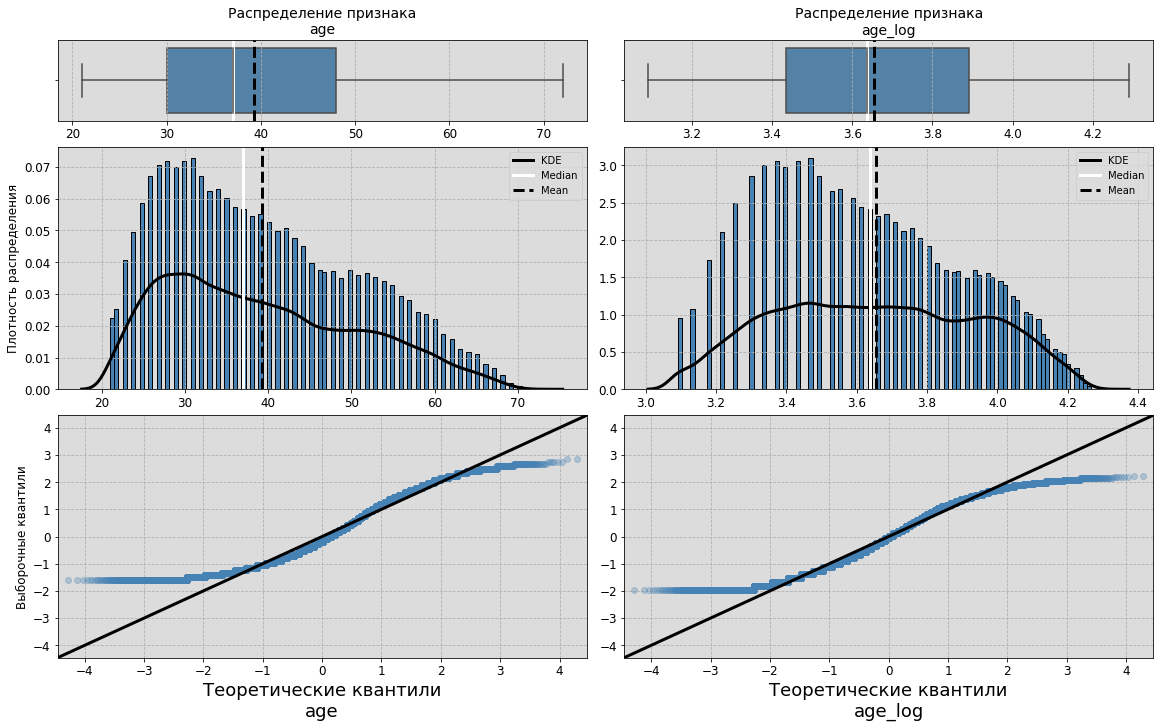

,Left,Right
Границы выбросов age,3.000000,75.00000
Кол-во выбросов age,0.000000,0.00000
Границы выбросов age_log,2.747238,4.57857
Кол-во выбросов age_log,0.000000,0.00000


---

### decline_app_cnt

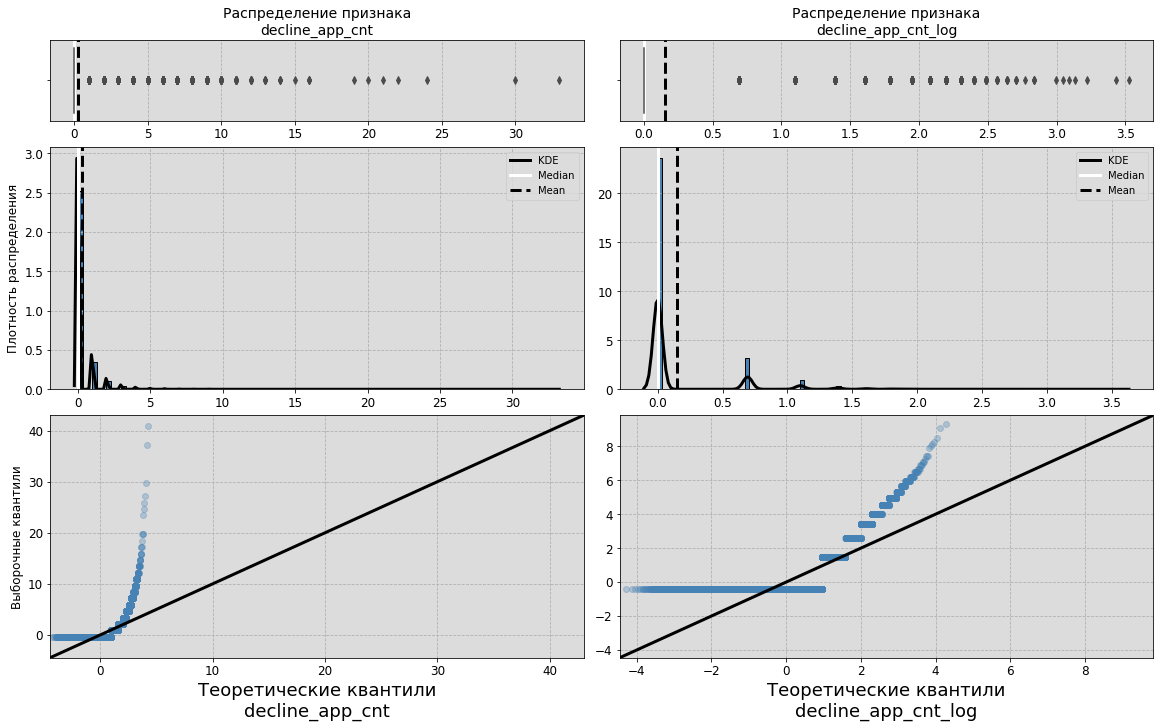

,Left,Right
Границы выбросов decline_app_cnt,0.0,0.0
Кол-во выбросов decline_app_cnt,0.0,18677.0
Границы выбросов decline_app_cnt_log,0.0,0.0
Кол-во выбросов decline_app_cnt_log,0.0,18677.0


---

### score_bki

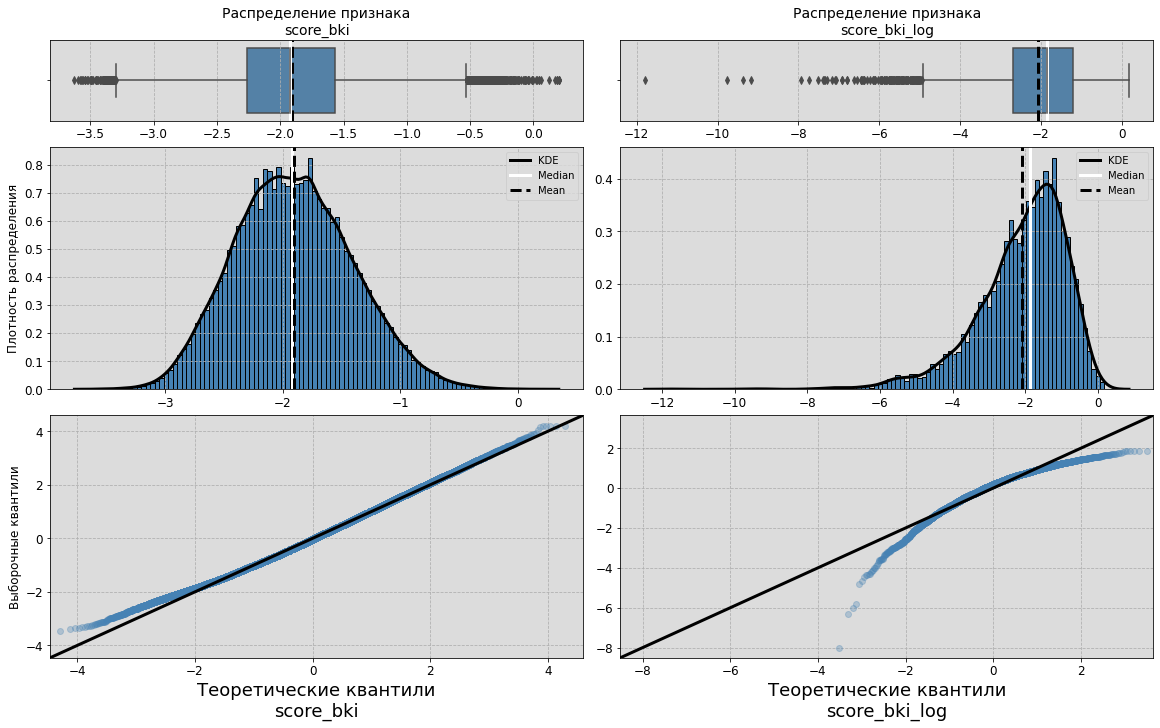

,Left,Right
Границы выбросов score_bki,-3.299252,-0.529070
Кол-во выбросов score_bki,82.000000,436.000000
Границы выбросов score_bki_log,-4.920565,1.010974
Кол-во выбросов score_bki_log,130.000000,0.000000


---

### bki_request_cnt

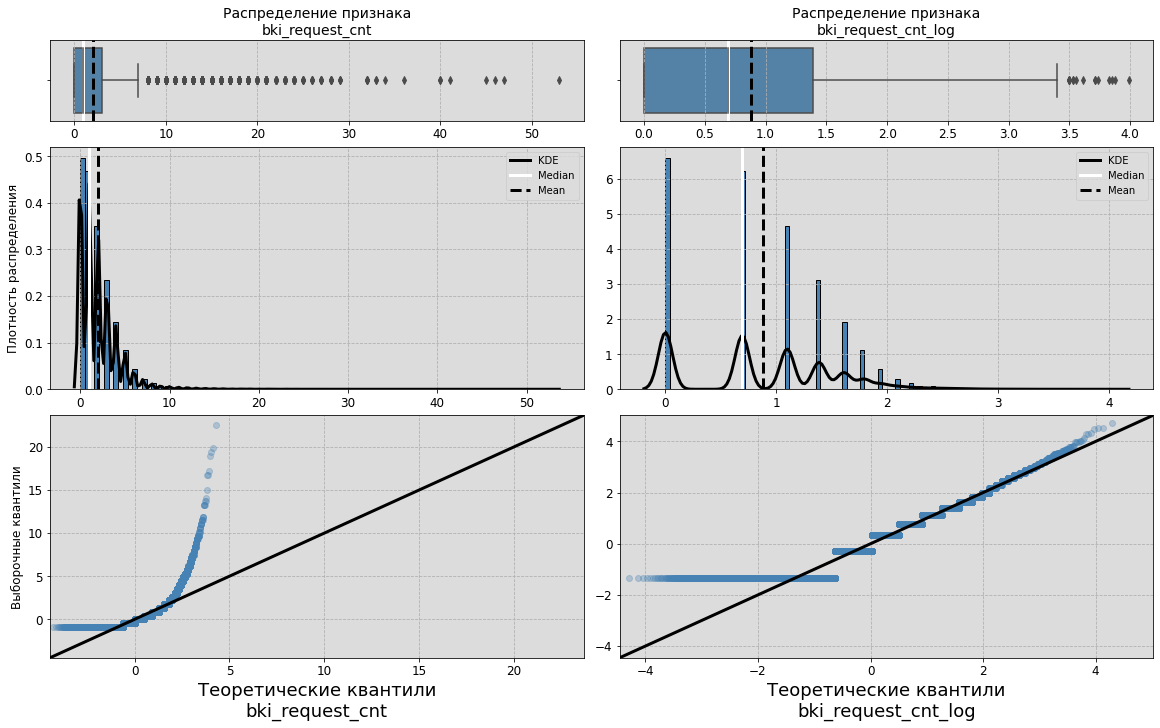

,Left,Right
Границы выбросов bki_request_cnt,-4.500000,7.500000
Кол-во выбросов bki_request_cnt,0.000000,2636.000000
Границы выбросов bki_request_cnt_log,-2.079442,3.465736
Кол-во выбросов bki_request_cnt_log,0.000000,15.000000


---

### income

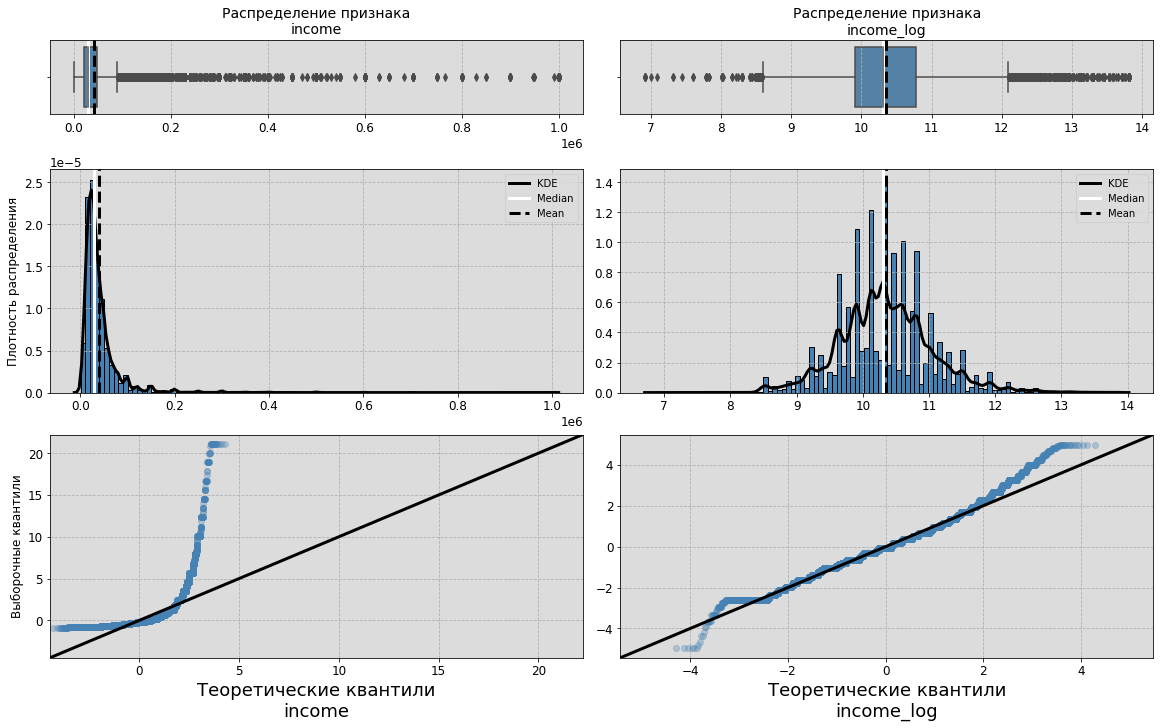

,Left,Right
Границы выбросов income,-22000.000000,90000.000000
Кол-во выбросов income,0.000000,7000.000000
Границы выбросов income_log,8.590378,12.092136
Кол-во выбросов income_log,875.000000,1734.000000


---

In [36]:
for col in num_lst:
    num_col_analyze(data, col)

<code>score_bki</code> имеет нормально распределение.

<code>age</code>, <code>decline_app_cnt</code>, <code>bki_request_cnt</code>, <code>income</code> имеют тяжёлый правый хвост, который значительно исправляет логарифмирование. Логарифмируем их перед применением в модели, а пока сохраним в отдельный список:

In [37]:
log_lst = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

Все переменные, кроме <code>age</code>, имеют выбросы. В дальнейшем попробуем избавиться от них.

Отдельно посмотрим на переменную <code>decline_app_cnt</code>. Судя по проверке на выбросы, подавляющее большинство значений в перменной равно нулю.  

Проверим это:

In [38]:
data[data['decline_app_cnt'] != 0].shape[0]

18677

Получается, что выбросами считаются все ненулевые значения. Оценим значимость этой переменной на фоне остальных числовых перменных:

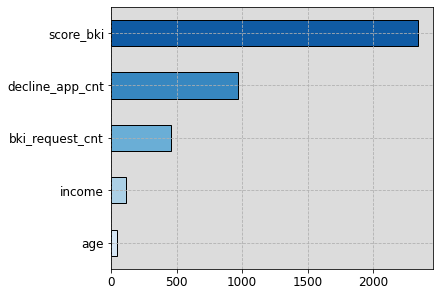

In [39]:
f_classifier(data[data['sample'] == 1], num_lst, 'default')

Пременная имеет достаточнуют значиность. Очевидно, что просто очистить выбросы, либо заменить их средним\медианой будет неправильно. В дальнейшем решим, что с этим делать.

Помотрим на матрицу корреляций для числовых переменных:

In [40]:
corr_matrix(data, num_lst, add_col='default', matrix_name='num_lst')

,age,decline_app_cnt,score_bki,bki_request_cnt,income,default
age,1.00,0.11,0.10,0.05,0.02,0.03
decline_app_cnt,0.11,1.00,0.19,0.16,0.02,0.11
score_bki,0.10,0.19,1.00,0.16,0.01,0.18
bki_request_cnt,0.05,0.16,0.16,1.00,0.08,0.08
income,0.02,0.02,0.01,0.08,1.00,0.04
default,0.03,0.11,0.18,0.08,0.04,1.00


Сильных корреляций не выявлено. Все переменные применимы для модели.  

Проанализируем числовые переменные относительно целевой перменной <code>default</code>

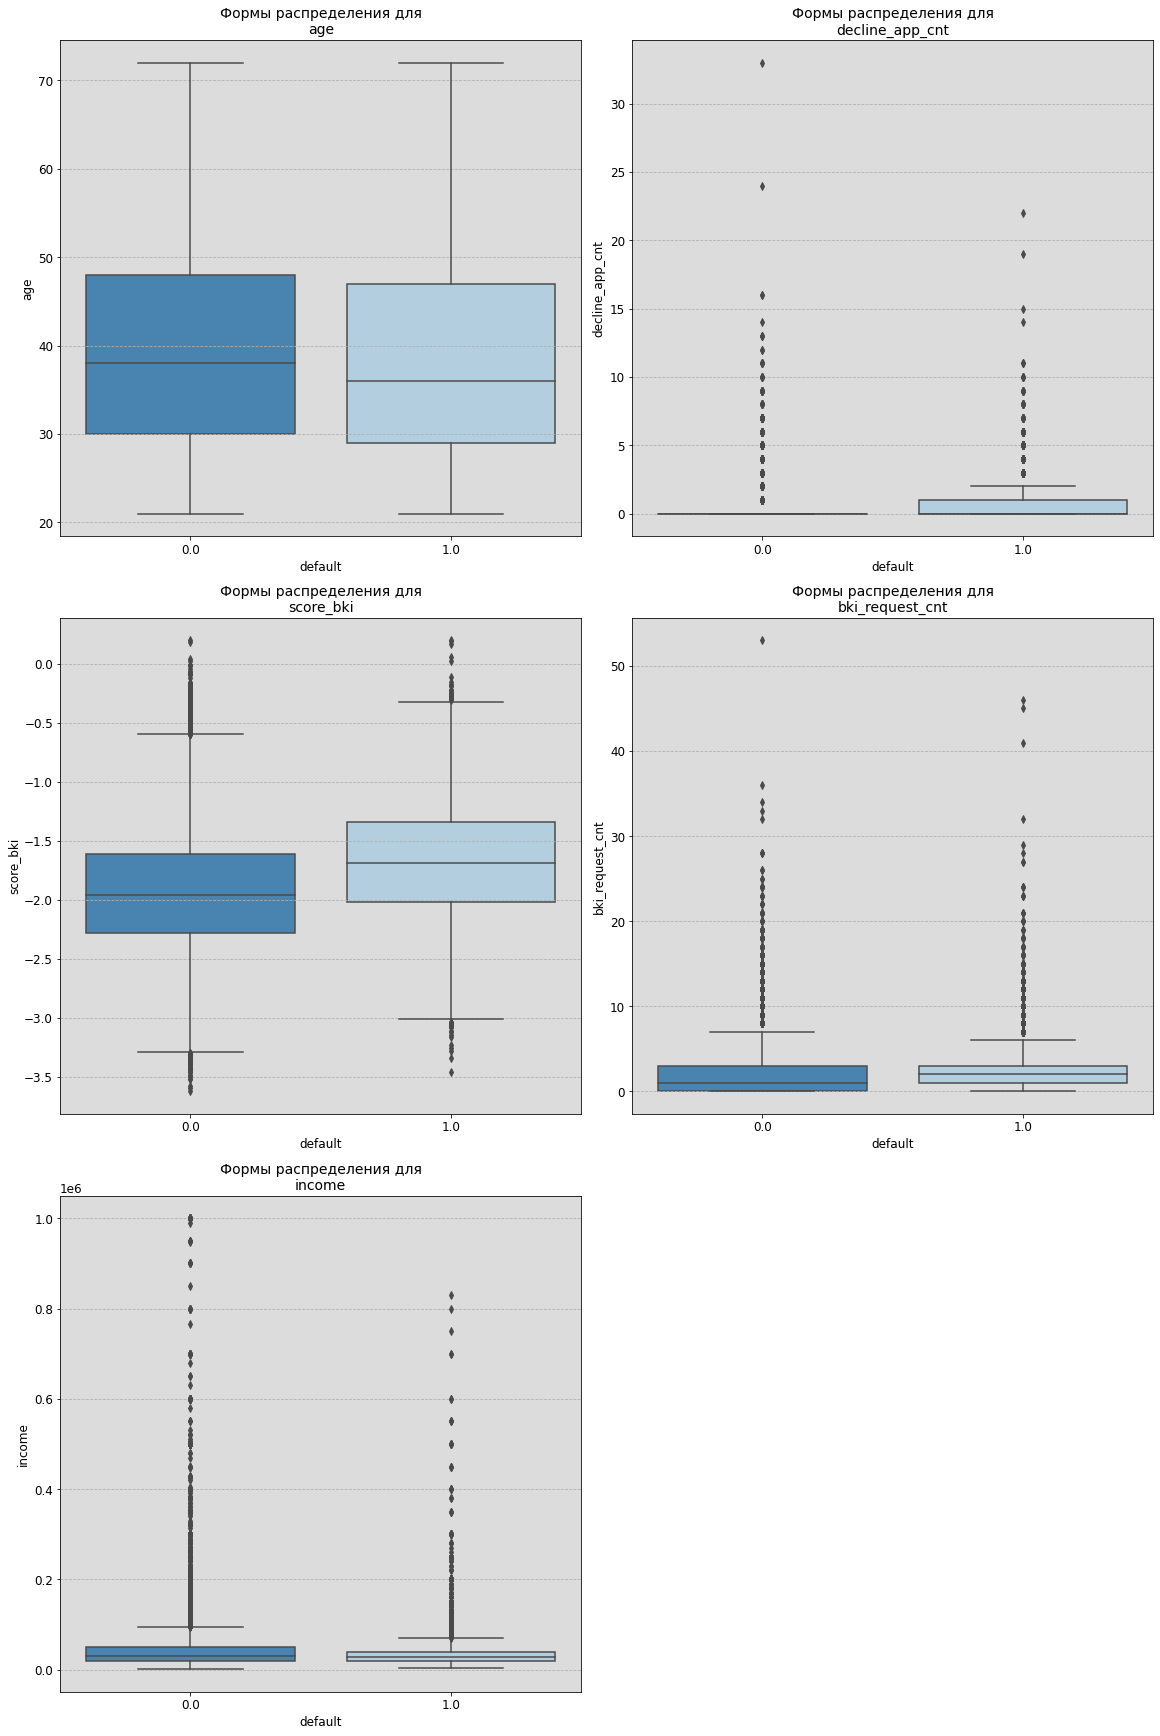

In [41]:
get_boxplot(data, 'default', num_lst)

В среднем дефолтные заемщики моложе, уже имели отказы по кредитам, делали больше запросов и имеют более низкий доход.

[К содержанию](#0)

---

<a id="3.2"></a>
# [3.2 Категориальные переменные](#3.2)

Посмотрим на распределения категориальных перменных относительно целевой перменной <code>default</code>.

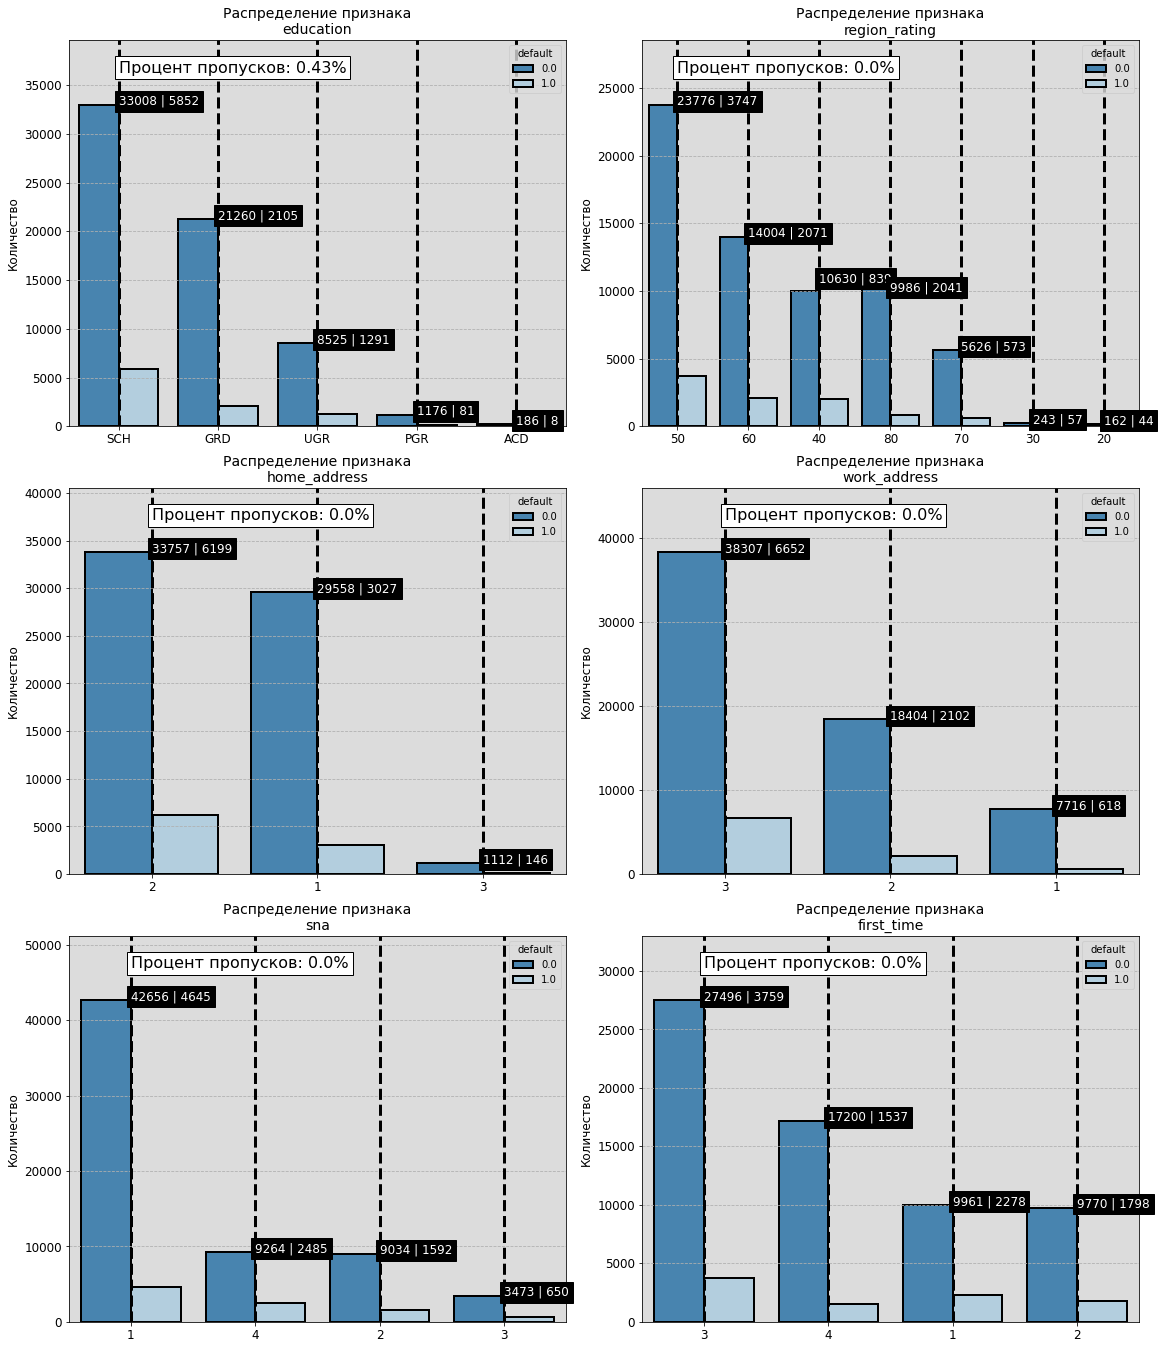

In [42]:
get_countplot(data, cat_lst, hue='default')

Для начала заполним пропуски в переменной <code>education</code> случайными значениями в зависимости от веса значения:

In [43]:
cat_fill_missing(data, 'education')

In [44]:
data['education'].isnull().sum()

0

Рикну расшифровать значения переменной <code>education</code> так:
1. SCH - школьное образование
2. GRD - профессиональное образование
3. UGR - высшее образование
4. PGR - кандидат наук
5. ACD - высшие ученые степени

И на основе этого делать дальнейшие выводы.

В среднем дефолнтый заемщик имеет более низкий уровень образования. С другой стороны люди с низким уровнем образования чаще обращаются за кредитом. Просмотрим на уровень оборозования относительно дохода:

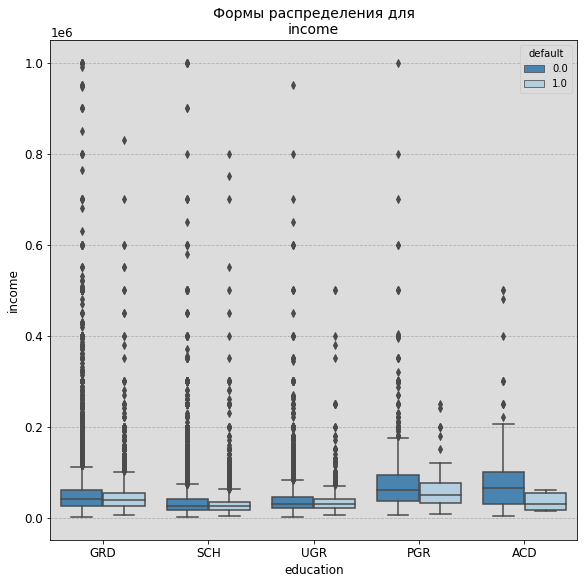

In [45]:
get_boxplot(data, 'education', 'income', hue='default')

На основе полученных данных можно сделать вывод: 
* чем ниже уровень образования, тем ниже доход; 
* чем ниже доход, тем чаще возникает нужда в дополнительных средствах;
* чем ниже уровень образования и дохода, тем выше риск невыполнения долговых обязательств.

Интересно, что у людей с высшим образованием доход в среднем ниже, чем у людей с профессиональным образованием. А также чаще возникают проблемы с заемами.

Попробуем разобраться с значениями остальных категориальных переменных:

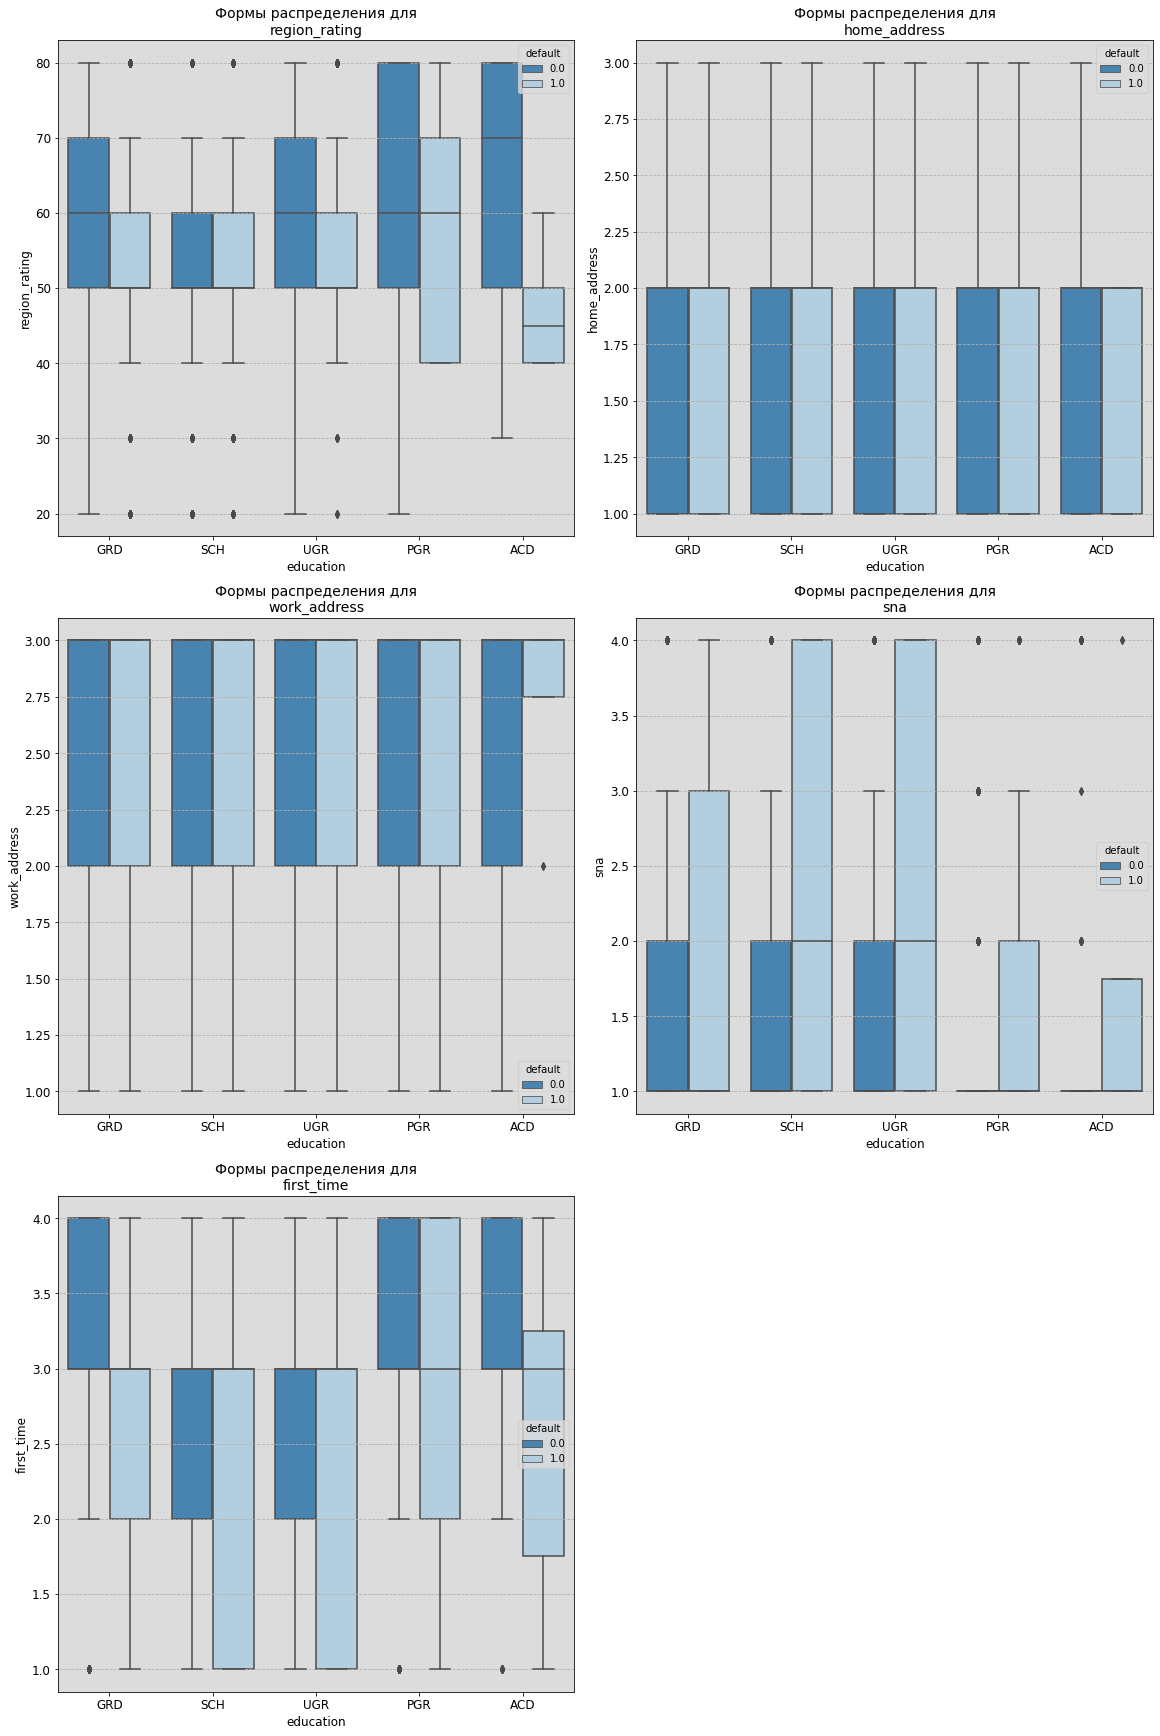

In [46]:
temp_lst = ['region_rating', 'home_address',
            'work_address', 'sna', 'first_time']
get_boxplot(data, 'education', temp_lst, hue='default')

Большиство людей проживают в регионах со средним рейтингом. Соответсвенно клиенты банков чаще оттуда. В регионах с высоким рейтингом высок шанс встретить надежного заемщика с хорошим уровнем образования.  
Интересно, что ненадежные заемщики с высшими учеными степенями в основном проживают в регионах с рейтингом от 40 до 50.

Чем выше значение в переменной <code>sna</code>, тем выше возможность дефолта. Возможно это критерий родственной связи. Можно предположить, что, чем лучше уровень жизни заемщика, тем меньше шанс, что в его окружении есть неблагонадежные клиенты банка.

Перменную <code>first_time</code> можно интерпретировать так: чем выше значение, тем длинее, богаче и благонадежнее кредитная история клиента.

Адресные переменные интерпретировать не удалось.

Преобразуем значения в переменной <code>education</code> в цифровой формат, что бы оценить значимость:

In [47]:
education_dict = {
    'SCH': 1,
    'GRD': 2,
    'UGR': 3,
    'PGR': 4,
    'ACD': 5,
}

data['education'] = data['education'].map(education_dict)

Оценим значимость категориальных перменных:

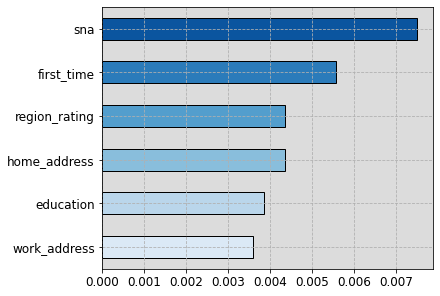

In [48]:
mutual_classifier(data[data['sample'] == 1], cat_lst, 'default')

Наибольшую значимость имеют кредитная история и связь с клиентами банка.

Помотрим на матрицу корреляций:

In [49]:
corr_matrix(data, cat_lst, add_col='default', matrix_name='cat_lst')

,education,region_rating,home_address,work_address,sna,first_time,default
education,1.00,0.11,0.02,0.02,0.06,0.07,0.06
region_rating,0.11,1.00,0.23,0.25,0.08,0.09,0.09
home_address,0.02,0.23,1.00,0.73,0.11,0.06,0.08
work_address,0.02,0.25,0.73,1.00,0.11,0.06,0.08
sna,0.06,0.08,0.11,0.11,1.00,0.53,0.13
first_time,0.07,0.09,0.06,0.06,0.53,1.00,0.11
default,0.06,0.09,0.08,0.08,0.13,0.11,1.00


Достаточно высокая, но не критичная, корреляция между адресными переменными. Пока сохраним их в датасете.  
Также достаточно высока корреляция между переменными <code>first_time</code> и <code>sna</code>.

[К содержанию](#0)

---

<a id="3.3"></a>
# [3.3 Бинарные перменные](#3.3)

Посмотрим на распределения категориальных перменных относительно целевой перменной <code>default</code>.

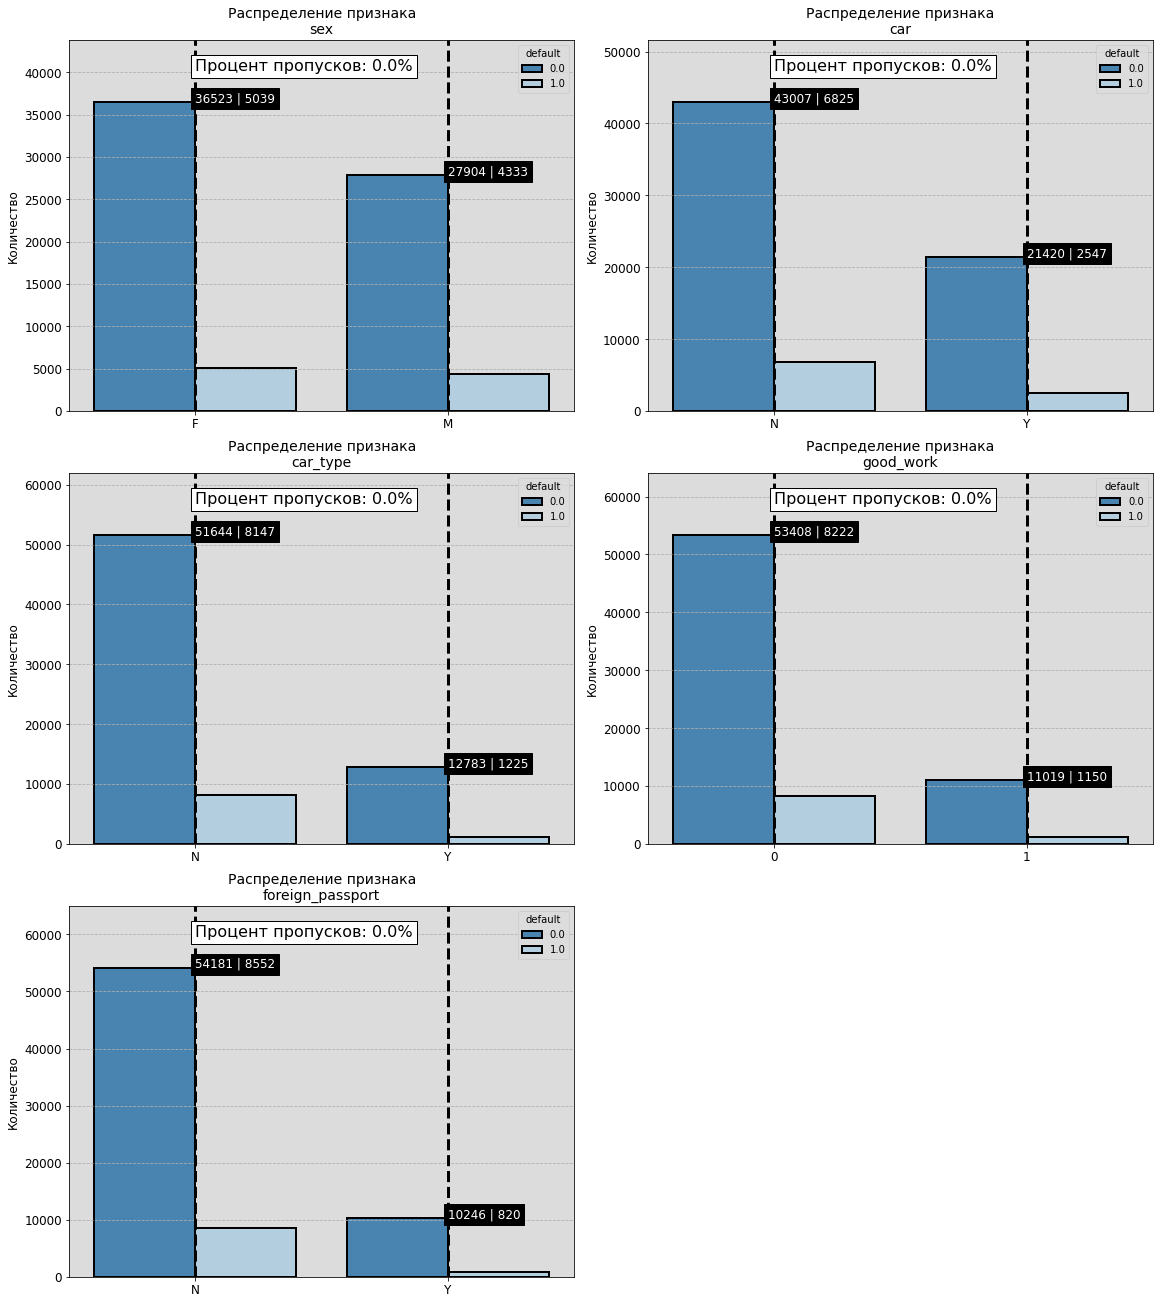

In [50]:
get_countplot(data, bin_lst, hue='default')

Судя по графикам среднестатистический клиент банка - это человек без машины, хорошей работы и загранпаспорта.

Наличие иномарки, хорошей работы и загранпаспорта повышает шансы банка на то, что кредит будет погашен в срок.

Для оценки значимости преобразуем бинарные перменные с помощью *LabelEncoder*:

In [51]:
label_encoder = LabelEncoder()

for col in bin_lst:
    data[col] = label_encoder.fit_transform(data[col])

И оценим значимость бинарных перменных:

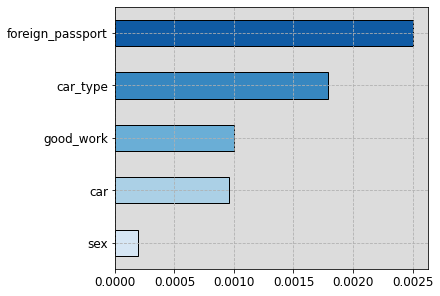

In [52]:
mutual_classifier(data[data['sample'] == 1], bin_lst, 'default')

Наибольшую значимость имеют флаг наличия/отсутсвия загранпаспорта и марка машины.  

Помотрим на матрицу корреляций:

In [53]:
corr_matrix(data, bin_lst, add_col='default', matrix_name='bin_lst')

,sex,car,car_type,good_work,foreign_passport,default
sex,1.00,0.28,0.22,0.04,0.09,0.02
car,0.28,1.00,0.70,0.00,0.11,0.04
car_type,0.22,0.70,1.00,0.02,0.15,0.06
good_work,0.04,0.00,0.02,1.00,0.05,0.04
foreign_passport,0.09,0.11,0.15,0.05,1.00,0.07
default,0.02,0.04,0.06,0.04,0.07,1.00


Достаточно высокая, но не критичная, корреляция между car и car_type. Пока сохраним их в датасете.

[К содержанию](#0)

---

<a id="3.4"></a>
# [3.4 Временная переменная app_date](#3.4)

Для начала преобразуем переменную в datetime:

In [54]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

Посмотрим в какой период подавались заявки:

In [55]:
min_date = data['app_date'].min().date()
max_date = data['app_date'].max().date()
printmd(f'Заявки подавались в период с **{min_date}** по **{max_date}**')

Заявки подавались в период с **2014-01-01** по **2014-04-30**

В дальнейшем попробуем создать новые признаки на основе этой переменной.

[К содержанию](#0)

---

<a id="4"></a>
# [4. Начальная модель](#4)

Построим начальную модель, чтобы проверить качество начальных данных и оценить метрики, которые в дальнейшем можно улучшить.

In [56]:
train_models_data = data[data['sample'] == 1][num_lst+cat_lst+bin_lst+['default']]

Логорифмируем и стандатизируем числовые переменные, а также преобразуем категориальные переменные в подходящию для модели форму:

In [57]:
train_models_data = features_transform(train_models_data, log_lst, num_lst, cat_lst)

### Датафрейм для модели

,age,decline_app_cnt,score_bki,bki_request_cnt,income,sex,car,car_type,good_work,foreign_passport,default,education_1,education_2,education_3,education_4,education_5,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
36349,1.104220,0.000000,-0.127490,0.0,-0.583482,1,1,1,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
36350,0.997653,0.000000,0.563354,0.5,-0.521725,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
36351,-0.828882,1.098612,0.743336,0.0,0.000000,1,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1


Разделим данные для обучения следующим образом:

In [58]:
X = train_models_data.drop(['default'], axis=1)
y = train_models_data['default'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

Обучим модель и посмотрим на результат:

### test_model

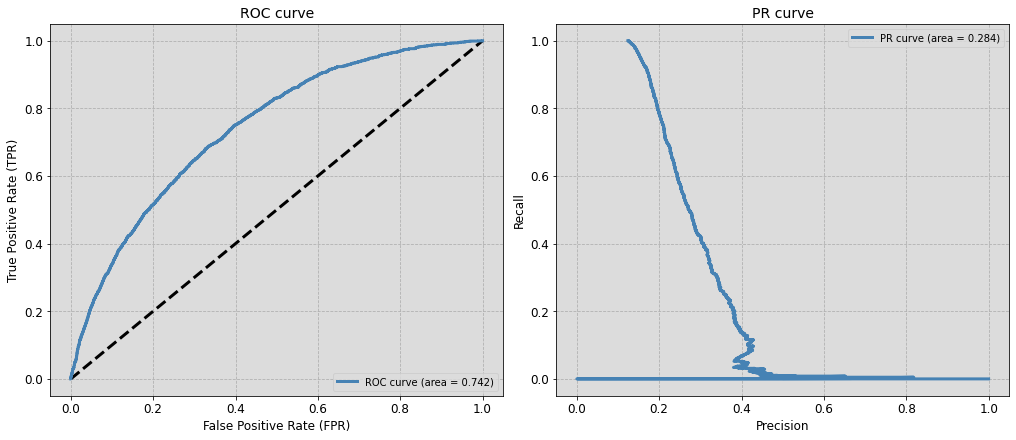

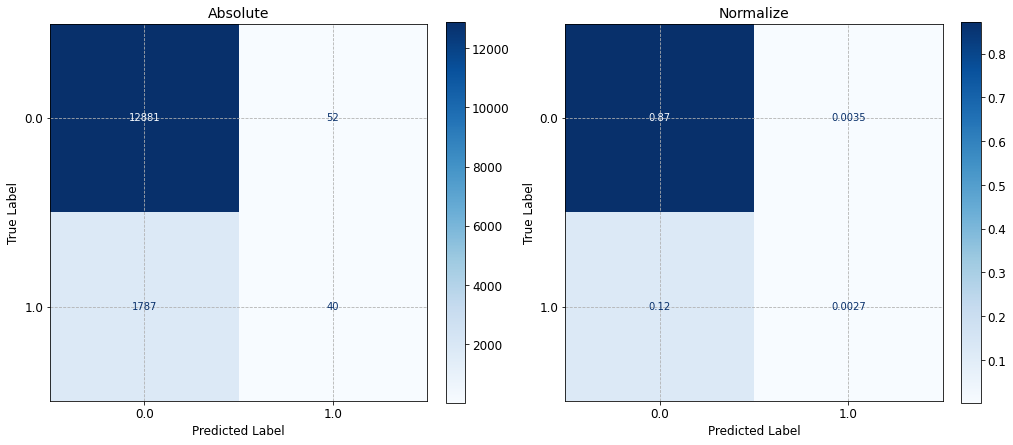

,Value
Accuracy,0.875407
Precision,0.434783
Recall,0.021894
F1-score,0.041688


In [59]:
test_model = LogisticRegression(random_state=RANDOM_SEED,
                                solver=solver)
test_model.fit(X_train, y_train)

model_metrics_and_plots(test_model, 
                        X_train, X_test,
                        y_train, y_test, 
                        model_name='test_model')

Высокое значение *ROC-AUC*, но значение метрики *F1-score* и *Recall* явно указвают, что у модель в текущем виде не состоятельна. Матрица ошибок показывает, что модель абсолютно не умеет угадвать дефолтных клиентов, вследствие чего банк рискует потерять деньги. Сказывается несбалансировать выборки.

Попробуем улучшить результаты с помощью добавления новых признаков и избавится от дисбаланса.

[К содержанию](#0)

---

<a id="5"></a>
# [5. Создание новых признаков](#5)

Для начала создадим новые признак на основе <code>app_date</code>.

In [60]:
# Разница в днях между датой подачи заявки и текущем днем
data['days_to_now'] = (datetime.now() - data['app_date']).dt.days

In [61]:
num_lst = num_lst + ['days_to_now']

Создадим новые категориальные признаки на основе имеющихся:

In [62]:
# Нет машины/отечественная/иномарка
data['cars'] = data[['car', 'car_type']].apply(
    lambda x: str(x[0])+str(x[1]), axis=1)
data['cars'] = label_encoder.fit_transform(data['cars'])

In [63]:
cat_lst = cat_lst+['cars']

In [64]:
# Общий категоризатор домашнего и рабочего адресов
data['addresses'] = data[['home_address', 'work_address']].apply(
    lambda x: str(x[0])+str(x[1]), axis=1)
data['addresses'] = label_encoder.fit_transform(data['addresses'])

In [65]:
cat_lst = cat_lst+['addresses']

Cоздадим бинарный признак на основе <code>'decline_app_bin'</code>

In [66]:
# Были отказы/не было отказов
data['decline_app_bin'] = data['decline_app_cnt'].apply(
    lambda x: 0 if x == 0 else 1)

In [67]:
bin_lst = bin_lst + ['decline_app_bin']

Создадим новые числовые признаки. Сначала определим средний доход в зависимости от других признаков:

In [68]:
temp_lst = ['education', 'region_rating', 'addresses', 'age']
income = mean_of_cols(data, temp_lst, 'income')

Созданы ['mean_income_education', 'mean_income_region_rating', 'mean_income_addresses', 'mean_income_age']


In [69]:
num_lst = num_lst + income

Сделаем тоже самое для возраста:

In [70]:
temp_lst = ['education', 'addresses', 'bki_request_cnt']
age = mean_of_cols(data, temp_lst, 'age')

Созданы ['mean_age_education', 'mean_age_addresses', 'mean_age_bki_request_cnt']


In [71]:
num_lst = num_lst + age

Создадим полиномиальные признаки:

In [72]:
# Корни
data['sqrt_income'] = data['income'].apply(lambda x: np.sqrt(x))
data['sqrt_bki_request_cnt'] = data['bki_request_cnt'].apply(
    lambda x: np.sqrt(x) if x != 0 else x)

In [73]:
num_lst = num_lst + ['sqrt_income'] + ['sqrt_bki_request_cnt']

In [74]:
data['mult_income_bki_request_cnt'] = data[['income', 'bki_request_cnt']
                                           ].apply(lambda x: x[0]*x[1] if x[1] != 0 else 1, axis=1)
data['div_income_bki_request_cnt'] = data[['income', 'bki_request_cnt']
                                          ].apply(lambda x: x[0]/x[1] if x[1] != 0 else 1, axis=1)
data['mult_age_bki_request_cnt'] = data[['age', 'bki_request_cnt']
                                        ].apply(lambda x: x[0]*x[1] if x[1] != 0 else 1, axis=1)
data['div_age_bki_request_cnt'] = data[['age', 'bki_request_cnt']
                                       ].apply(lambda x: x[0]/x[1] if x[1] != 0 else 1, axis=1)

In [75]:
num_lst = num_lst + ['mult_income_bki_request_cnt']
num_lst = num_lst + ['div_income_bki_request_cnt']
num_lst = num_lst + ['mult_age_bki_request_cnt']
num_lst = num_lst + ['div_age_bki_request_cnt']

Удалим ненужные признаки:

In [76]:
num_lst.remove('decline_app_cnt')
cat_lst.remove('home_address')
cat_lst.remove('work_address')
bin_lst.remove('car')
bin_lst.remove('car_type')

Оценим значимость новых признаков:

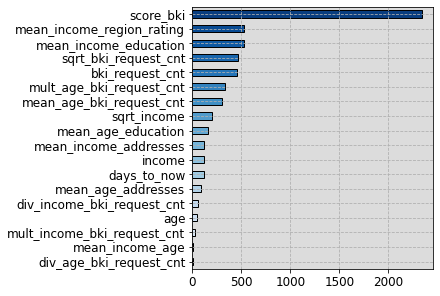

In [77]:
f_classifier(data[data['sample'] == 1], num_lst, 'default')

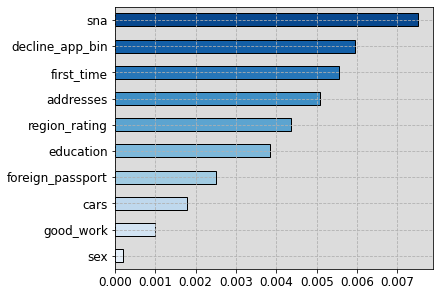

In [78]:
mutual_classifier(data[data['sample'] == 1], cat_lst+bin_lst, 'default')

Самым значимым признаком, с большим отрывом от остальных, является скоринговый бал. Возраст и большиство созданых на его основе признаков имеют крайне маленькую значимость. С другой стороны значимы доход, количество запросов и их производные. Интресно, что признаки, объединяющие доход и количество отзывов имеют малую значимость.

Из категориальных\бинарных признаков в лидерах два созданых: флаг отказа и объединенные адреса.

И посмтрим на общую матрицу корреляций:

In [79]:
corr_matrix(data, num_lst+cat_lst+bin_lst,
            add_col='default', matrix_name='general')

,age,score_bki,bki_request_cnt,income,days_to_now,mean_income_education,mean_income_region_rating,mean_income_addresses,mean_income_age,mean_age_education,mean_age_addresses,mean_age_bki_request_cnt,sqrt_income,sqrt_bki_request_cnt,mult_income_bki_request_cnt,div_income_bki_request_cnt,mult_age_bki_request_cnt,div_age_bki_request_cnt,education,region_rating,sna,first_time,cars,addresses,sex,good_work,foreign_passport,decline_app_bin,default
age,1.00,0.10,0.05,0.02,0.02,0.10,0.09,0.02,0.15,0.19,0.04,0.06,0.07,0.04,0.02,0.03,0.27,0.29,0.17,0.09,0.06,0.08,0.05,0.01,0.13,0.07,0.04,0.11,0.03
score_bki,0.10,1.00,0.16,0.01,0.06,0.03,0.02,0.01,0.02,0.02,0.00,0.14,0.01,0.14,0.09,0.03,0.13,0.06,0.01,0.01,0.07,0.07,0.05,0.02,0.05,0.01,0.02,0.20,0.18
bki_request_cnt,0.05,0.16,1.00,0.08,0.03,0.04,0.01,0.00,0.03,0.01,0.00,0.85,0.10,0.90,0.58,0.04,0.94,0.12,0.00,0.01,0.00,0.01,0.01,0.00,0.05,0.01,0.01,0.14,0.08
income,0.02,0.01,0.08,1.00,0.00,0.25,0.23,0.07,0.13,0.13,0.03,0.07,0.93,0.06,0.56,0.60,0.07,0.04,0.17,0.21,0.09,0.11,0.30,0.04,0.19,0.03,0.23,0.03,0.04
days_to_now,0.02,0.06,0.03,0.00,1.00,0.03,0.00,0.12,0.01,0.05,0.06,0.03,0.00,0.01,0.02,0.01,0.02,0.04,0.04,0.00,0.00,0.02,0.03,0.17,0.03,0.00,0.01,0.02,0.04
mean_income_education,0.10,0.03,0.04,0.25,0.03,1.00,0.13,0.02,0.05,0.51,0.01,0.03,0.32,0.02,0.13,0.16,0.01,0.04,0.68,0.12,0.11,0.13,0.18,0.00,0.04,0.18,0.18,0.05,0.08
mean_income_region_rating,0.09,0.02,0.01,0.23,0.00,0.13,1.00,0.26,0.00,0.10,0.02,0.01,0.31,0.02,0.10,0.13,0.02,0.06,0.11,0.92,0.10,0.10,0.09,0.27,0.11,0.08,0.27,0.04,0.08
mean_income_addresses,0.02,0.01,0.00,0.07,0.12,0.02,0.26,1.00,0.03,0.03,0.46,0.00,0.10,0.00,0.03,0.05,0.00,0.01,0.03,0.23,0.05,0.02,0.01,0.60,0.07,0.02,0.07,0.01,0.04
mean_income_age,0.15,0.02,0.03,0.13,0.01,0.05,0.00,0.03,1.00,0.02,0.03,0.03,0.17,0.03,0.07,0.07,0.02,0.06,0.01,0.00,0.07,0.10,0.12,0.07,0.07,0.03,0.04,0.03,0.01
mean_age_education,0.19,0.02,0.01,0.13,0.05,0.51,0.10,0.03,0.02,1.00,0.01,0.01,0.18,0.01,0.06,0.09,0.05,0.05,0.90,0.10,0.05,0.05,0.09,0.02,0.04,0.11,0.11,0.00,0.05


Появились сильно коррелирующие признаки. В основном связанные c <code>bki_request_cnt</code>. Вероятно 

Проанализируем новые признаки:

In [80]:
# Анализ распределения и наличия выбросов
# Длинная простыня из графиков
# for col in num_lst:
#     print(col)
#     get_distplot(data, col, log=True)
#     display_outliers(data, col, log=True)

На основе анализа сохраним признаки, которые потребуют логорифмирования и очистки от выбросов:

In [81]:
log_lst = ['age',
           'income',
           'mean_income_education',
           'sqrt_income',
           'sqrt_bki_request_cnt',
           'mult_income_bki_request_cnt',
           'div_income_bki_request_cnt',
           'mult_age_bki_request_cnt',
           'div_age_bki_request_cnt']
outliers_lst = ['score_bki',
                'income',
                'mean_income_age',
                'sqrt_income', ]

[К содержанию](#0)

---

<a id="6"></a>
# [6. Моделирование](#6)

Подготовим данные для модели. Логорифмируем и стандатизируем числовые переменные, очистим от выбросов, а также преобразуем категориальные переменные в подходящию для модели форму:

In [82]:
models_data = data[data['sample'] == 1][num_lst+cat_lst+bin_lst+['default']]
models_data = features_transform(models_data, log_lst, num_lst, cat_lst)
fix_outliers(models_data, outliers_lst)

### Датафрейм для модели

,age,score_bki,bki_request_cnt,income,days_to_now,mean_income_education,mean_income_region_rating,mean_income_addresses,mean_income_age,mean_age_education,mean_age_addresses,mean_age_bki_request_cnt,sqrt_income,sqrt_bki_request_cnt,mult_income_bki_request_cnt,div_income_bki_request_cnt,mult_age_bki_request_cnt,div_age_bki_request_cnt,sex,good_work,foreign_passport,decline_app_bin,default,education_1,education_2,education_3,education_4,education_5,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,cars_0,cars_1,cars_2,addresses_0,addresses_1,addresses_2,addresses_3,addresses_4,addresses_5,addresses_6,addresses_7,addresses_8
36349,1.104220,-0.127490,0.000000,-0.583482,0.553571,0.0,0.000000,-1.0,-2.113384,0.0,-1.0,-0.104892,-0.582995,0.000000,-0.073798,0.063642,0.033662,0.591867,1,0,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
36350,0.997653,0.563354,0.666667,-0.521725,-0.142857,0.0,0.000000,0.0,-1.861544,0.0,0.0,1.000000,-0.521336,0.310337,0.032733,-0.049453,0.291121,0.163612,0,0,0,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
36351,-0.828882,0.743336,0.000000,0.000000,0.553571,0.0,11.438273,-1.0,-1.002418,0.0,-1.0,-0.104892,0.000000,0.000000,-0.026588,0.118954,-0.185719,0.251819,1,0,1,1,0.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0


[К содержанию](#0)

---

<a id="6.1"></a>
# [6.1 Начальная модель с балансироваными весами](#6.1)

Чтобы решить решить проблему дисбаланса, сбалансируем классы с помощью параметра *class_weight*.

Посмотрим, что покажет модель, после внесенных изменений.

In [83]:
X = models_data.drop(['default'], axis=1)
y = models_data['default'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

### balanced_model

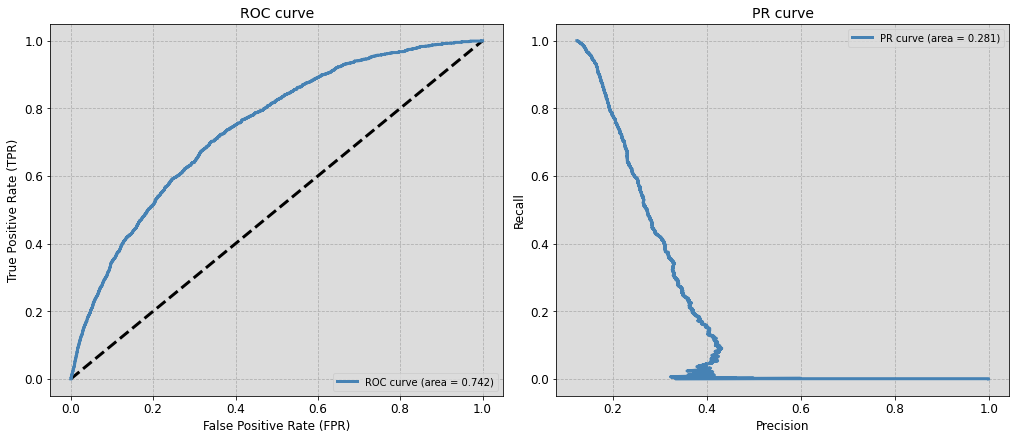

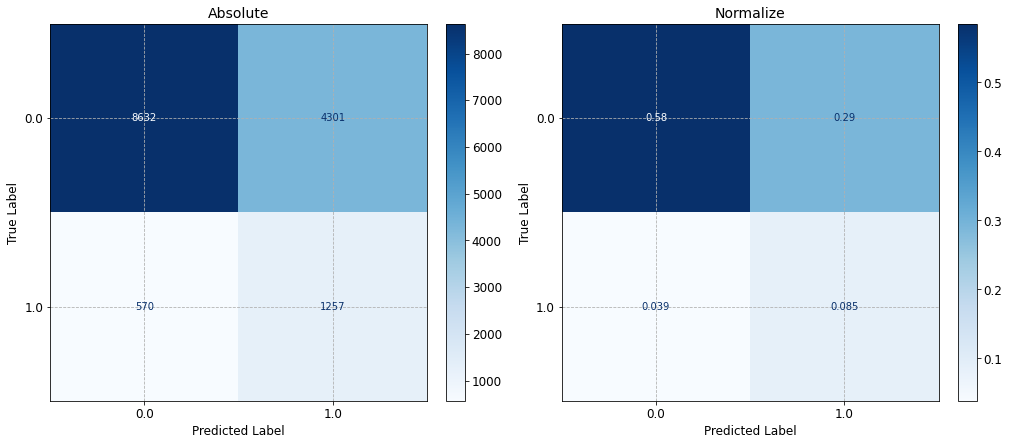

,Value
Accuracy,0.669986
Precision,0.226160
Recall,0.688013
F1-score,0.340420


In [84]:
balanced_model = LogisticRegression(random_state=RANDOM_SEED,
                                    solver=solver,
                                    class_weight='balanced')
balanced_model.fit(X_train, y_train)

model_metrics_and_plots(balanced_model, 
                        X_train, X_test,
                        y_train, y_test, 
                        model_name='balanced_model')

Значительно подросли чуствительность(*Recall*) и F1-score, но упали значения Accuracy и Precision. Модель стала значительно лучше угадывать дефолтных клиентов на несбалансированных данных.

[К содержанию](#0)

---

<a id="6.2"></a>
# [6.2 Регуляризация модели](#6.2)

Подберем параметры регуляризации с помощью GridSearchCV, чтобы получить лучшие значения метрик:

In [85]:
balanced_model = LogisticRegression(random_state=RANDOM_SEED,
                                    solver=solver,
                                    class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=6, random_state=RANDOM_SEED)

param_grid = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2'], 'multi_class': ['auto', 'ovr']}

gridsearch = GridSearchCV(balanced_model, param_grid, scoring='roc_auc', n_jobs=-1, cv=skf)
gridsearch.fit(X, y)
reg_model = gridsearch.best_estimator_

Посмотрим, какие параметры определил алгоритм:

In [86]:
best_parameters = reg_model.get_params()
param_df = pd.DataFrame.from_dict(best_parameters,
                                  orient='index',
                                  columns=['Value'])
display(pd.DataFrame.from_dict(best_parameters, orient='index'))

,0
C,1.112
class_weight,balanced
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,100
multi_class,auto
n_jobs,None
penalty,l2


Проверим, как работает модель на определенных параметрах:

### reg_model

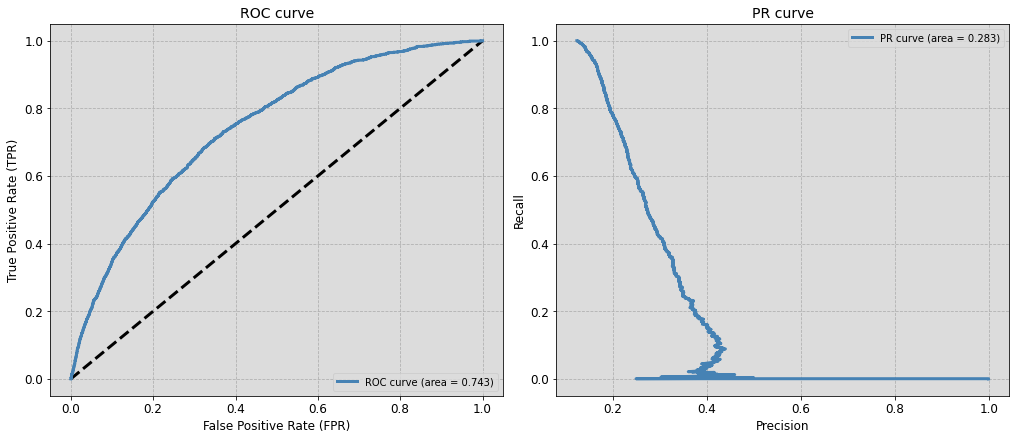

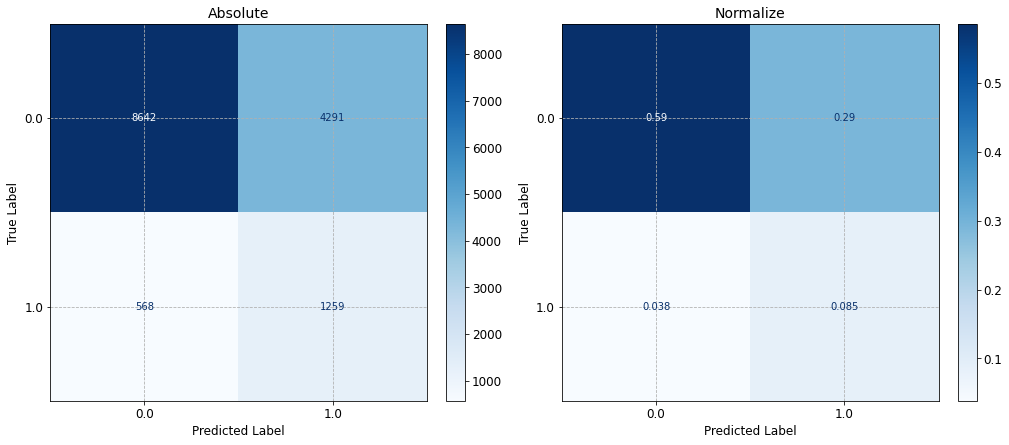

,Value
Accuracy,0.670799
Precision,0.226847
Recall,0.689108
F1-score,0.341331


In [87]:
model_metrics_and_plots(reg_model, 
                        X_train, X_test,
                        y_train, y_test, 
                        model_name='reg_model')

Удалось немного поднять значение ключевой метрики, но модель в целом работает так же.



[К содержанию](#0)

---

<a id="6.3"></a>
# [6.3 Отбор признаков](#6.3)

Посмтроим модель с определенными параметрами регуляризации и поищем признаки, которые ухудшают работу модели. Почередно удалим каждый признак, и проверим значение ключевой метрики.

In [88]:
X = models_data.drop(['default'], axis=1)
y = models_data['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

drop_model = LogisticRegression(random_state=RANDOM_SEED,
                                solver=solver,
                                class_weight='balanced', 
                                C=1.112,
                                penalty='l2', 
                                multi_class='auto', 
                                max_iter=100)
drop_model.fit(X_train, y_train)

LogisticRegression(C=1.112, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [89]:
drop_lst = search_bad_features(models_data, 'default', drop_model, X_test, y_test, r=5)

*Столбец для удаления:* ***age.***

*Значения метрики* ***ROC AUC - 0.74199***

*Столбец для удаления:* ***bki_request_cnt.***

*Значения метрики* ***ROC AUC - 0.74231***

*Столбец для удаления:* ***income.***

*Значения метрики* ***ROC AUC - 0.74241***

*Столбец для удаления:* ***mult_income_bki_request_cnt.***

*Значения метрики* ***ROC AUC - 0.74242***

*Столбец для удаления:* ***mean_income_education.***

*Значения метрики* ***ROC AUC - 0.74243***

*Столбец для удаления:* ***mult_age_bki_request_cnt.***

*Значения метрики* ***ROC AUC - 0.74247***

*Столбец для удаления:* ***mean_income_region_rating.***

*Значения метрики* ***ROC AUC - 0.74248***

*Столбец для удаления:* ***sqrt_bki_request_cnt.***

*Значения метрики* ***ROC AUC - 0.74251***

*Столбец для удаления:* ***mean_age_bki_request_cnt.***

*Значения метрики* ***ROC AUC - 0.74263***

*Столбец для удаления:* ***region_rating_20.***

*Значения метрики* ***ROC AUC - 0.74268***

*Столбец для удаления:* ***education_1.***

*Значения метрики* ***ROC AUC - 0.74269***

*Столбец для удаления:* ***mean_age_education.***

*Значения метрики* ***ROC AUC - 0.7427***

*Столбец для удаления:* ***education_4.***

*Значения метрики* ***ROC AUC - 0.74289***

*Столбец для удаления:* ***region_rating_30.***

*Значения метрики* ***ROC AUC - 0.74292***

*Столбец для удаления:* ***region_rating_40.***

*Значения метрики* ***ROC AUC - 0.74313***

*Столбец для удаления:* ***addresses_7.***

*Значения метрики* ***ROC AUC - 0.74316***

*Столбец для удаления:* ***addresses_0.***

*Значения метрики* ***ROC AUC - 0.74319***

Признаки для удаления: **age, bki_request_cnt, income, mult_income_bki_request_cnt, mean_income_education, mult_age_bki_request_cnt, mean_income_region_rating, sqrt_bki_request_cnt, mean_age_bki_request_cnt, region_rating_20, education_1, mean_age_education, education_4, region_rating_30, region_rating_40, addresses_7, addresses_0**

Удалим найденные признаки:

In [90]:
poor_models_data = models_data.drop(drop_lst, axis=1)

[К содержанию](#0)

---

<a id="6.4"></a>
# [6.4 Финальная модель](#6.4)

Попробуем найти оптимальные параметры регуляризации, чтобы найти лучшее значение ключевой метрики ROC AUC.

In [91]:
#Оптимальные параметры подбирались руками
X = poor_models_data.drop(['default'], axis=1)
y = poor_models_data['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

final_model = LogisticRegression(random_state=RANDOM_SEED,
                                solver=solver,
                                class_weight='balanced', 
                                C=3.4,
                                penalty='l2', 
                                multi_class='ovr', 
                                max_iter=1000)
final_model.fit(X_train, y_train)

y_prob = final_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.7431845174348314

Лучшее значение ключевой метрики ROC AUC, которого удалось добиться ручным перебором парметров - **0.7434**

Посмотрим на остальные мертрики финальной модели.

### final_model

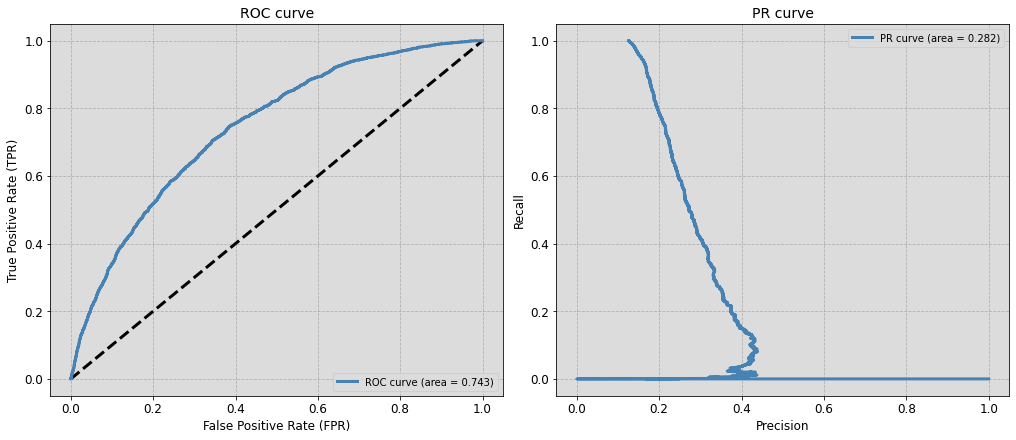

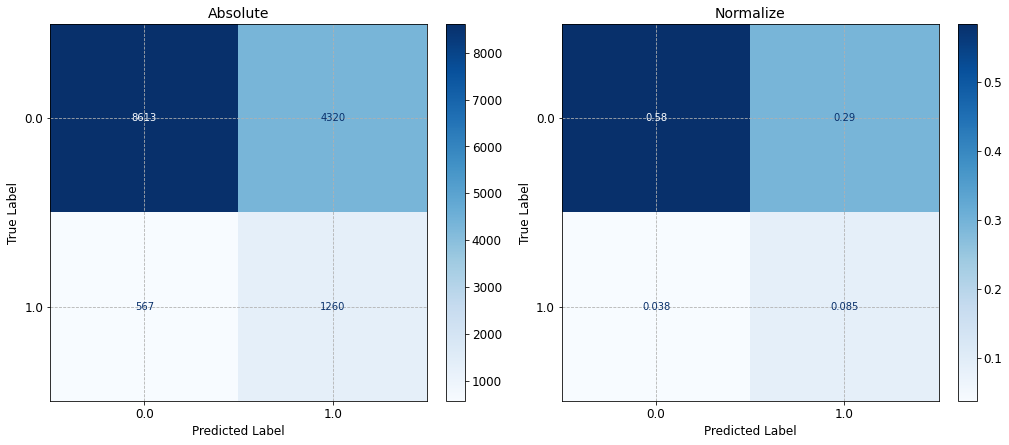

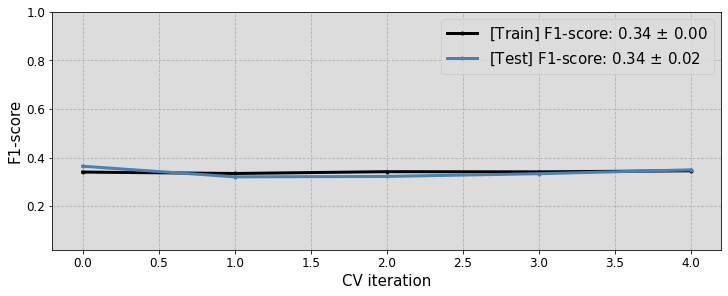

,Value
Accuracy,0.668902
Precision,0.225806
Recall,0.689655
F1-score,0.340219


In [92]:
model_metrics_and_plots(final_model, 
                        X_train, X_test,
                        y_train, y_test, 
                        model_name='final_model', cv_score=True)

После ручного подбора параметров и удаления признаков модель стала еще чуть лучше. 

[К содержанию](#0)

---

<a id="7"></a>
# [7. Submission](#7)

In [93]:
final_data = data[num_lst+cat_lst+bin_lst+['default']+['sample']]
final_data = features_transform(final_data, log_lst, num_lst, cat_lst, view=False)
fix_outliers(final_data, outliers_lst)
final_data = final_data.drop(drop_lst, axis=1)

In [94]:
X_train= final_data[final_data['sample'] == 1].drop(['default', 'sample'], axis=1)
y_train = final_data[final_data['sample'] == 1]['default'].values
X_test = final_data[final_data['sample'] == 0].drop(['default', 'sample'], axis=1)

In [95]:
final_model = LogisticRegression(random_state=RANDOM_SEED,
                                solver=solver,
                                class_weight='balanced', 
                                C=3.4,
                                penalty='l2', 
                                multi_class='ovr', 
                                max_iter=1000)
final_model.fit(X_train, y_train)

y_prob = final_model.predict_proba(X_test)[:, 1]

In [96]:
submit = pd.DataFrame(test_data['client_id'])
submit['default']=y_prob
submit.to_csv('submission.csv', index=False)

[К содержанию](#0)